# import all relevant libraries 

In [1451]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings 
warnings.filterwarnings('ignore')
# use label encoding to encode the categorical columns in the data
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost import XGBRegressor


In [1452]:
# set the number of columns to display to 100
pd.set_option('display.max_columns', 100)

# Define Functions

In [1453]:
def MachineLearningModels(features, target):

    X = features.copy()
    y = target.copy()

    # scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # define models
    models = {
        'Linear Regression': LinearRegression(),
        # 'Simple Vector Regression': SVR(),
        'XGBoost': xgb.XGBRegressor()
    }

    # calculate rmse for each model
    for name, model in models.items():
        cv = KFold(n_splits=5, shuffle=True, random_state=1)
        rmse = np.sqrt(-cross_val_score(model, X_scaled, y, scoring='neg_mean_squared_error', cv=cv))
        print(f'{name} RMSE: {round(rmse.mean(), 2)}')
        print(f'-----------------------------------')

In [1454]:
def impute_outliers_IQR(df, columns):
  """
  Imputes outliers in a DataFrame using the IQR method.
  Args:
      df (pandas.DataFrame): The DataFrame containing the data.
      columns (list): A list of column names to impute outliers in.
  Returns:
      pandas.DataFrame: The DataFrame with imputed outliers.
  """
  df_copy = df.copy()  # Create a copy to avoid modifying the original DataFrame

  for col in columns:
    # Calculate IQR
    Q1 = df_copy[col].quantile(0.25)
    Q3 = df_copy[col].quantile(0.75)
    IQR = Q3 - Q1

    # Lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Impute outliers with median
    df_copy.loc[df_copy[col] < lower_bound, col] = df_copy[col].median()
    df_copy.loc[df_copy[col] > upper_bound, col] = df_copy[col].median()

  return df_copy

In [1455]:
# create a label encoder function, that takes in a dataframe and encode it using LabelEncoder
labelencoder = LabelEncoder()
def label_encoder(df):
    df_copy = df.copy()
    for col in df_copy.columns:
        if df_copy[col].dtype in ['object', 'bool', 'category']:
            # df_copy[col] = pd.factorize(df_copy[col])[0]
            df_copy[col] = labelencoder.fit_transform(df_copy[col])
    return df_copy

# create a one hot encoder function, that takes in a dataframe and encode it using pd.get_dummies
def one_hot_encoder(df):
    df_copy = df.copy()
    for col in df_copy.columns:
        if df_copy[col].dtype in ['object', 'bool', 'category']:
            df_copy = pd.get_dummies(df_copy, columns=[col], drop_first=True)
            # Replace True/False with 1/0 in the encoded DataFrame
            df_copy = df_copy.replace({True: 1, False: 0})

    return df_copy

In [1456]:
# Create a KNN imputer with a suitable number of neighbors (adjust k as needed)
imputer = KNNImputer(n_neighbors=5)

def knn_impute(df):
    df_copy = df.copy()
    imputer = KNNImputer(n_neighbors=5)
    # fit and transform the data
    if 'price' in df.columns:
        df_imputed = imputer.fit_transform(df_copy.drop('price', axis=1))
        df_imputed = pd.DataFrame(df_imputed,  columns=df_copy.drop('price', axis=1).columns)
        df_imputed['price'] = df_copy['price']
    else:
        df_imputed = imputer.fit_transform(df_copy)
        df_imputed = pd.DataFrame(df_imputed,  columns=df_copy.columns)
    return df_imputed

In [1457]:
# create a mean or mode imputer function
def mean_mode_imputer(df):
    df_copy = df.copy()
    for col in df_copy.columns:
        # check if the column is a numerical column
        if df_copy[col].dtype in ['int64', 'float64']:
            df_copy[col].fillna(df_copy[col].mean(), inplace=True)

        # if not numerical, impute with mode
        else:
            df_copy[col].fillna(df_copy[col].mode()[0], inplace=True)
    return df_copy

In [1458]:
def plot_numerical_features_grid(df, ncols=3, figsize=(10, 10)):
    """
    Plots a grid of histograms with kernel density estimates for numerical features 
    (excluding binary features) in a pandas dataframe.

    Args:
        df (pandas.DataFrame): The dataframe containing features.
        ncols (int, optional): The number of columns in the grid plot. Defaults to 3.
        figsize (tuple, optional): The size of the figure in inches. Defaults to (10, 10).
    """
    # Get numerical features excluding binary features (unique values of 2)
    numerical_features = df.select_dtypes(include=['int64', 'float64'])
    numerical_features = numerical_features.loc[:, (numerical_features.nunique() != 2)]
    nfeatures = len(numerical_features.columns)

    # Adjust number of rows based on features and columns
    nrows = int(np.ceil(nfeatures / ncols))

    # Create a figure for plotting
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    # Iterate through features and plot histograms with KDE
    for i, feature_name in enumerate(numerical_features.columns):
        sns.histplot(ax=axes[i], data=numerical_features, x=feature_name, bins=50, kde=True)
        mean_value = numerical_features[feature_name].mean()
        median_value = numerical_features[feature_name].median()
        axes[i].axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
        axes[i].axvline(median_value, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')
        axes[i].legend(loc='best')
        axes[i].set_title(feature_name)
        axes[i].set_ylabel('Frequency')
        axes[i].set_xlabel(None)

    # Hide any remaining empty subplots
    for j in range(nfeatures, len(axes)):
        axes[j].axis('off')

    fig.tight_layout()
    plt.show()


In [1459]:

def plot_numerical_features_boxplot_grid(df, ncols=3, figsize=(10, 10), highlight_outliers=True, show_mean=True, show_median=True):
    """
    Plots a grid of boxplots for numerical features (excluding binary features) 
    in a pandas dataframe, with optional outlier highlighting, mean, and median.

    Args:
        df (pandas.DataFrame): The dataframe containing features.
        ncols (int, optional): The number of columns in the grid plot. Defaults to 3.
        figsize (tuple, optional): The size of the figure in inches. Defaults to (10, 10).
        highlight_outliers (bool, optional): Whether to highlight outliers using IQR rule. Defaults to True.
        show_mean (bool, optional): Whether to show the mean as a marker on the plot. Defaults to True.
        show_median (bool, optional): Whether to show the median as a marker on the plot. Defaults to True.
    """

    # Get numerical features excluding binary features (unique values of 2)
    numerical_features = df.select_dtypes(include=['number']).loc[:, df.nunique() > 2]
    nfeatures = len(numerical_features.columns)

    # Adjust number of rows based on features and columns
    nrows = int(np.ceil(nfeatures / ncols))

    # Create a figure for plotting
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize, squeeze=False)

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Calculate IQR for outlier highlighting (if enabled)
    if highlight_outliers:
        q1 = numerical_features.quantile(0.25)
        q3 = numerical_features.quantile(0.75)
        iqr = q3 - q1

    # Iterate through features and plot boxplots
    for i, feature_name in enumerate(numerical_features.columns):
        ax = axes[i]
        sns.boxplot(
            ax=ax,
            x=df[feature_name],
            showmeans=show_mean,
            meanprops={"marker":"o", "markerfacecolor":"yellow", "markeredgecolor":"black"},
            medianprops={"linestyle":"-", "color":"green"}
        )
        if show_mean:
            mean_value = df[feature_name].mean()
            ax.axvline(x=mean_value, color='red', linestyle='dashdot', linewidth=1)

        if show_median:
            median_value = df[feature_name].median()
            ax.axvline(x=median_value, color='green', linestyle='dashed', linewidth=1)
  
        ax.legend(loc='best', labels=['Mean: {:.2f}'.format(mean_value), 'Median: {:.2f}'.format(median_value)])
        if highlight_outliers:
            # Highlight outliers using IQR rule (optional)
            lower_bound = q1[feature_name] - 1.5 * iqr[feature_name]
            upper_bound = q3[feature_name] + 1.5 * iqr[feature_name]
            outliers = df[(df[feature_name] < lower_bound) | (df[feature_name] > upper_bound)]
            sns.scatterplot(
                ax=ax,
                x=outliers[feature_name],
                y=np.zeros_like(outliers[feature_name]),
                color="red",
                marker="o",
                s=5
            )
        ax.set_title(feature_name)
        # remove xlabels
        ax.set_xlabel(None)

    # Hide any remaining empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # Adjust layout (optional)
    fig.tight_layout()

    plt.show()


# Data Preprocessing

In [1460]:
# load dataset
df_data = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [1461]:
ids = df_test['id']

### Data Shape

In [1462]:
# check the shape of the data
print('Train data shape:', df_data.shape)
print('Test data shape:', df_test.shape)

Train data shape: (54273, 13)
Test data shape: (36183, 12)


In [1463]:
df_data.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,Ford,F-150 Lariat,2018,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Blue,Gray,None reported,Yes,11000
1,1,BMW,335 i,2007,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,6-Speed M/T,Black,Black,None reported,Yes,8250
2,2,Jaguar,XF Luxury,2009,91491,Gasoline,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Purple,Beige,None reported,Yes,15000
3,3,BMW,X7 xDrive40i,2022,2437,Hybrid,335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Gray,Brown,None reported,Yes,63500
4,4,Pontiac,Firebird Base,2001,111000,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,White,Black,None reported,Yes,7850


In [1464]:
df_test.head()

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,54273,Mercedes-Benz,E-Class E 350,2014,73000,Gasoline,302.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,A/T,White,Beige,None reported,Yes
1,54274,Lexus,RX 350 Base,2015,128032,Gasoline,275.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Silver,Black,None reported,Yes
2,54275,Mercedes-Benz,C-Class C 300,2015,51983,Gasoline,241.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Blue,White,None reported,Yes
3,54276,Land,Rover Range Rover 5.0L Supercharged Autobiogra...,2018,29500,Gasoline,518.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,White,White,At least 1 accident or damage reported,Yes
4,54277,BMW,X6 xDrive40i,2020,90000,Gasoline,335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,White,Black,At least 1 accident or damage reported,Yes


In [1465]:
del df_data['id']
del df_test['id']

### Data Types

In [1466]:
df_data.dtypes

brand           object
model           object
model_year       int64
milage           int64
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
clean_title     object
price            int64
dtype: object

In [1467]:
df_test.dtypes

brand           object
model           object
model_year       int64
milage           int64
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
clean_title     object
dtype: object

### Nunique

In [1468]:
# how many unique values are there in each column
df_data.nunique()

brand             53
model           1827
model_year        34
milage          3212
fuel_type          7
engine          1061
transmission      46
ext_col          260
int_col          124
accident           2
clean_title        1
price           1481
dtype: int64

In [1469]:
df_test.nunique()

brand             53
model           1791
model_year        34
milage          2973
fuel_type          7
engine          1038
transmission      44
ext_col          230
int_col          111
accident           2
clean_title        1
dtype: int64

In [1470]:
# delete the columns with only one unique value
del df_data['clean_title']
del df_test['clean_title']

### Isnull

In [1471]:
# check for nulls
df_data.isnull().sum()

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
price           0
dtype: int64

In [1472]:
df_test.isnull().sum()

brand           0
model           0
model_year      0
milage          0
fuel_type       0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
dtype: int64

### Duplicates

In [1473]:
# check for duplicates
df_data.duplicated().sum()

0

In [1474]:
df_test.duplicated().sum()

0

### Outliers

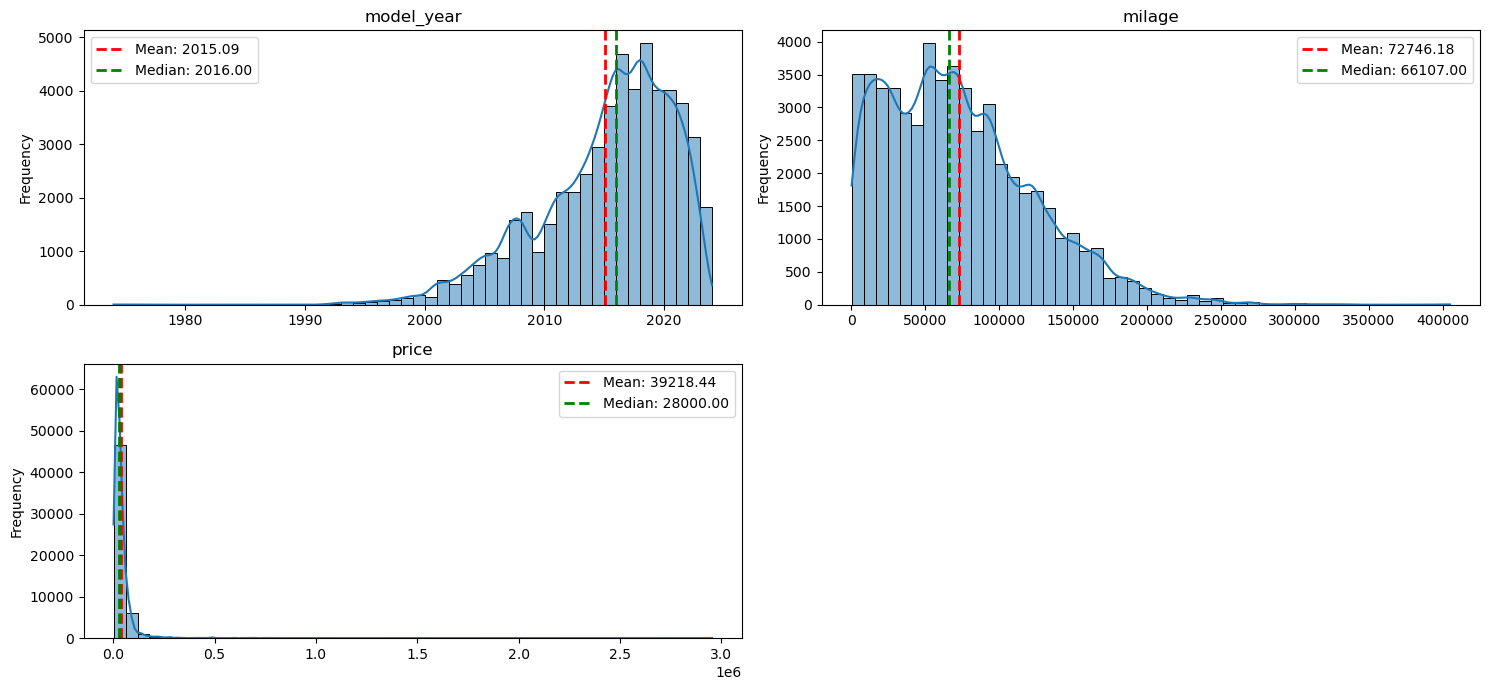

In [1475]:
plot_numerical_features_grid(df_data, ncols=2, figsize=(15, 7))

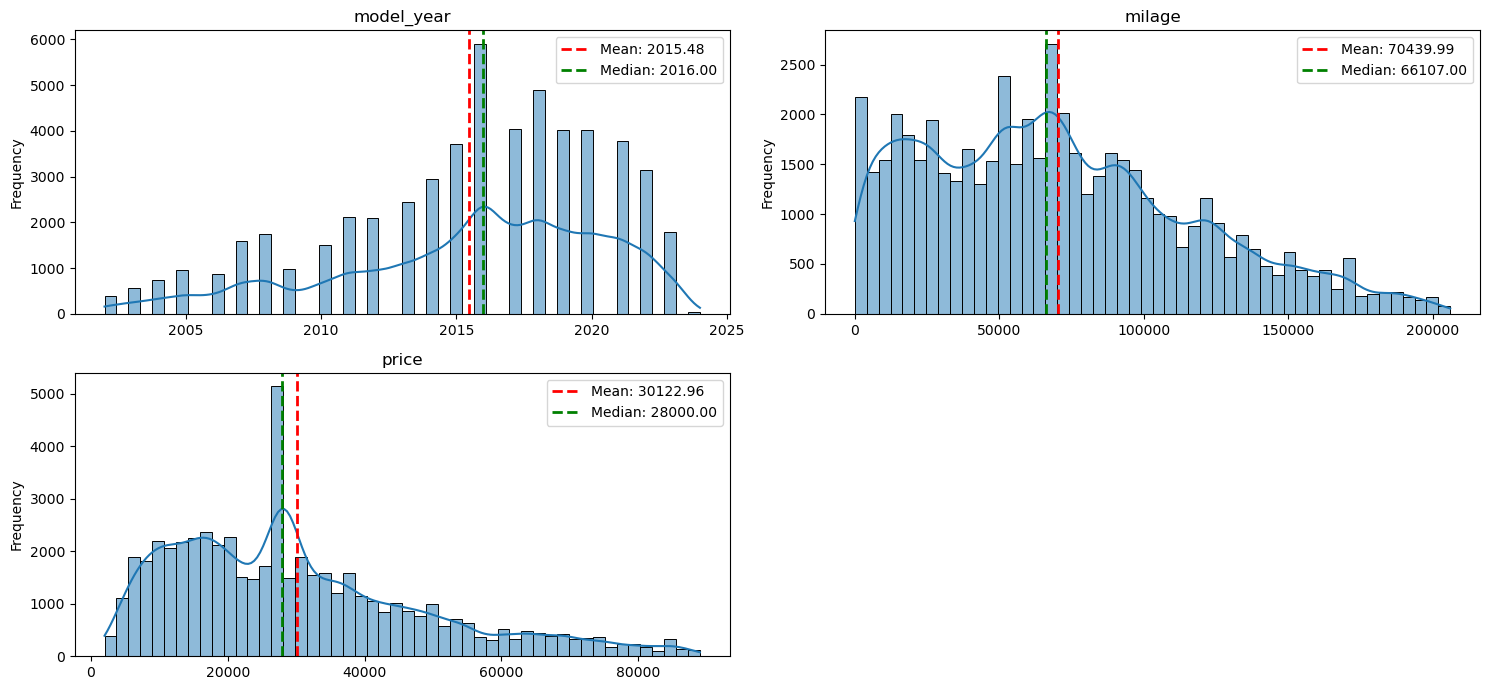

In [1476]:
# impute outliers in the data
plot_numerical_features_grid(impute_outliers_IQR(df_data, ['price', 'model_year', 'milage']), ncols=2, figsize=(15, 7))

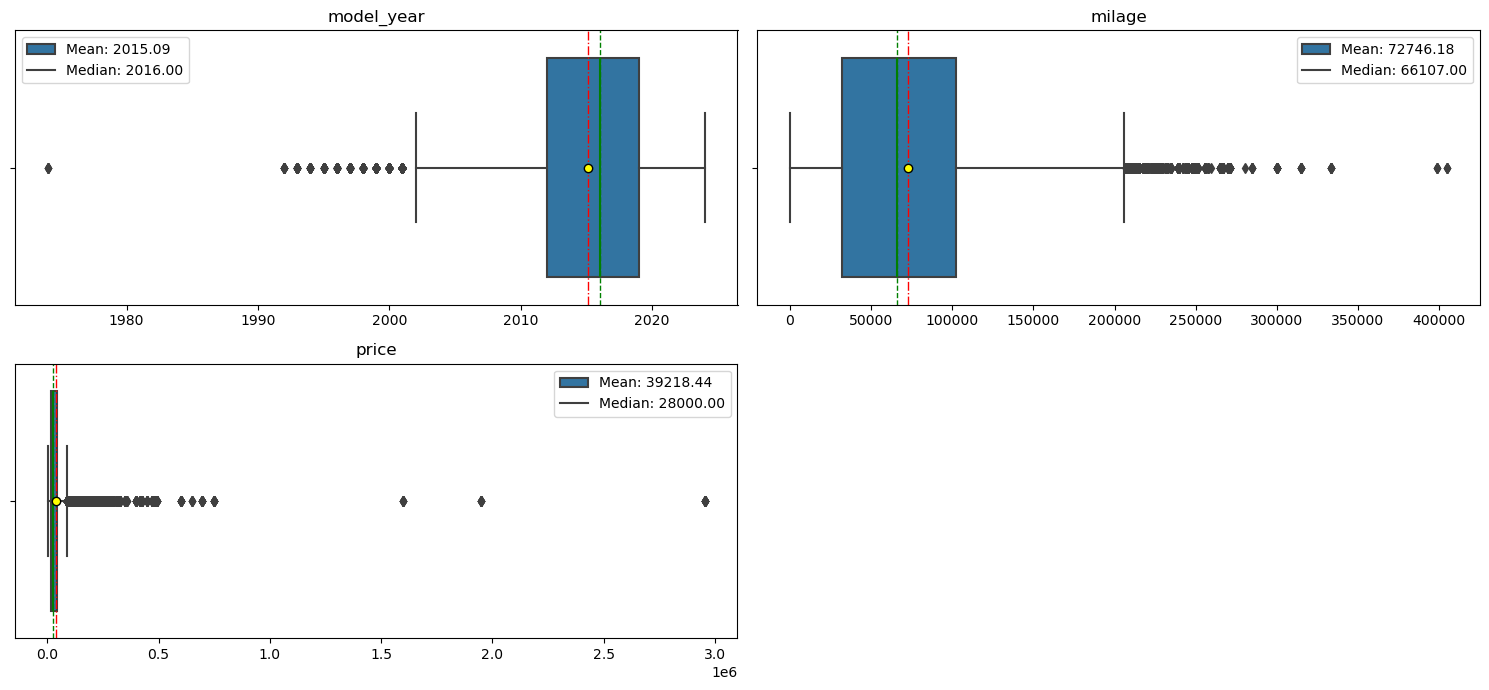

In [1477]:
plot_numerical_features_boxplot_grid(df_data, ncols=2, figsize=(15, 7))

- The dataset contains outliers, we will impute the outliers using the IQR later on.

# Data Analysis

## Univariate Analysis

#### Brand

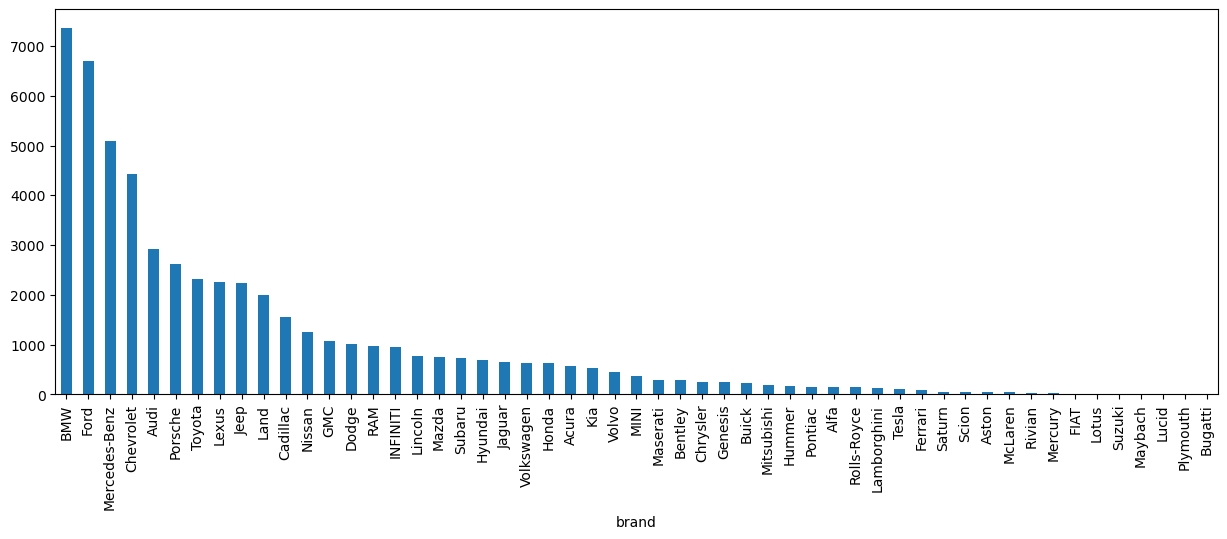

In [1478]:
df_data['brand'].value_counts(ascending=False).plot(kind='bar', figsize=(15,5));


#### Transmission

In [1479]:
df_data['transmission'].value_counts(ascending=False)

transmission
A/T                                                   16757
8-Speed A/T                                            7287
Transmission w/Dual Shift Mode                         6454
6-Speed A/T                                            5944
6-Speed M/T                                            3618
7-Speed A/T                                            3415
10-Speed A/T                                           2187
8-Speed Automatic                                      1189
5-Speed A/T                                            1185
9-Speed A/T                                            1073
4-Speed A/T                                             764
5-Speed M/T                                             718
CVT Transmission                                        692
10-Speed Automatic                                      642
6-Speed Automatic                                       516
Automatic                                               441
M/T                        

-  A lot of cleaning is needed on transmission. We can extract number of gears and transmission type.
-  We also need to handle cases where the number of gears or transmission types are not specified.

## Bivariate Analysis

#### Price vs Milage

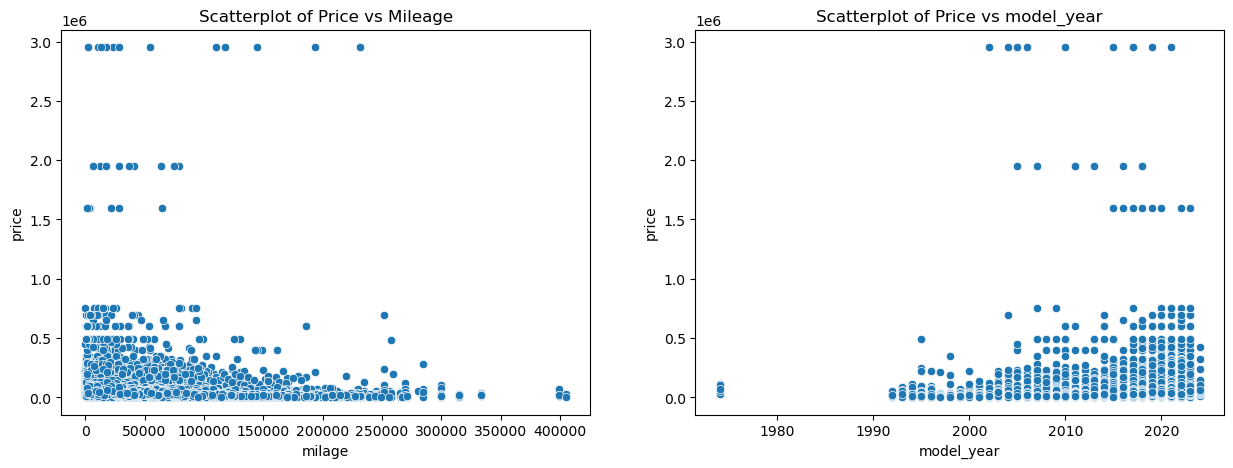

In [1480]:
# Plot a scatterplot between price and mileage, and between price and year
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.scatterplot(x='milage', y='price', data=df_data)
plt.title('Scatterplot of Price vs Mileage')
plt.subplot(1,2,2)
sns.scatterplot(x='model_year', y='price', data=df_data)
plt.title('Scatterplot of Price vs model_year')
plt.show()


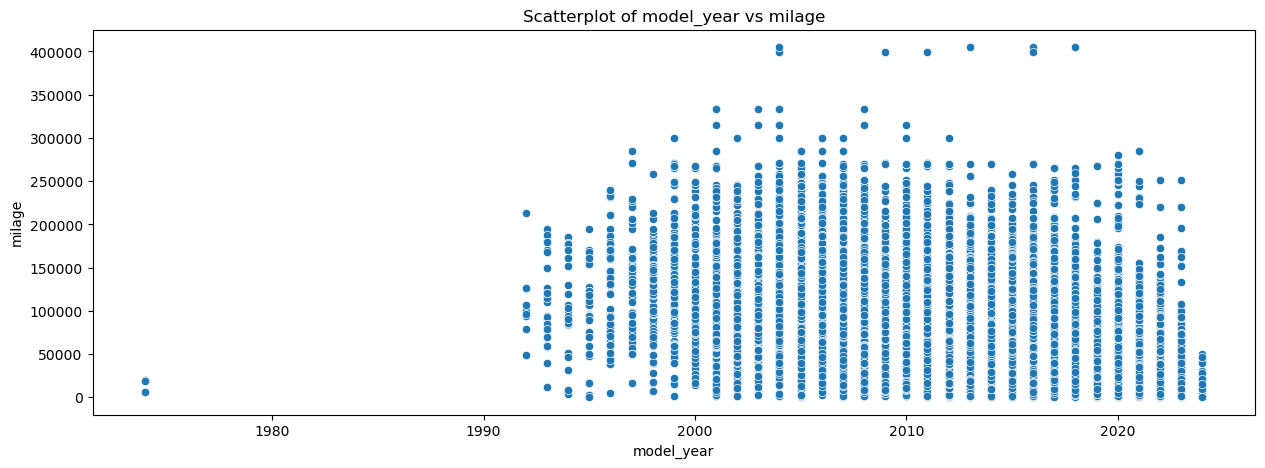

In [1481]:
# Plot model_year vs milage
plt.figure(figsize=(15,5))
sns.scatterplot(x='model_year', y='milage', data=df_data)
plt.title('Scatterplot of model_year vs milage')
plt.show()

#### Average price by Brand

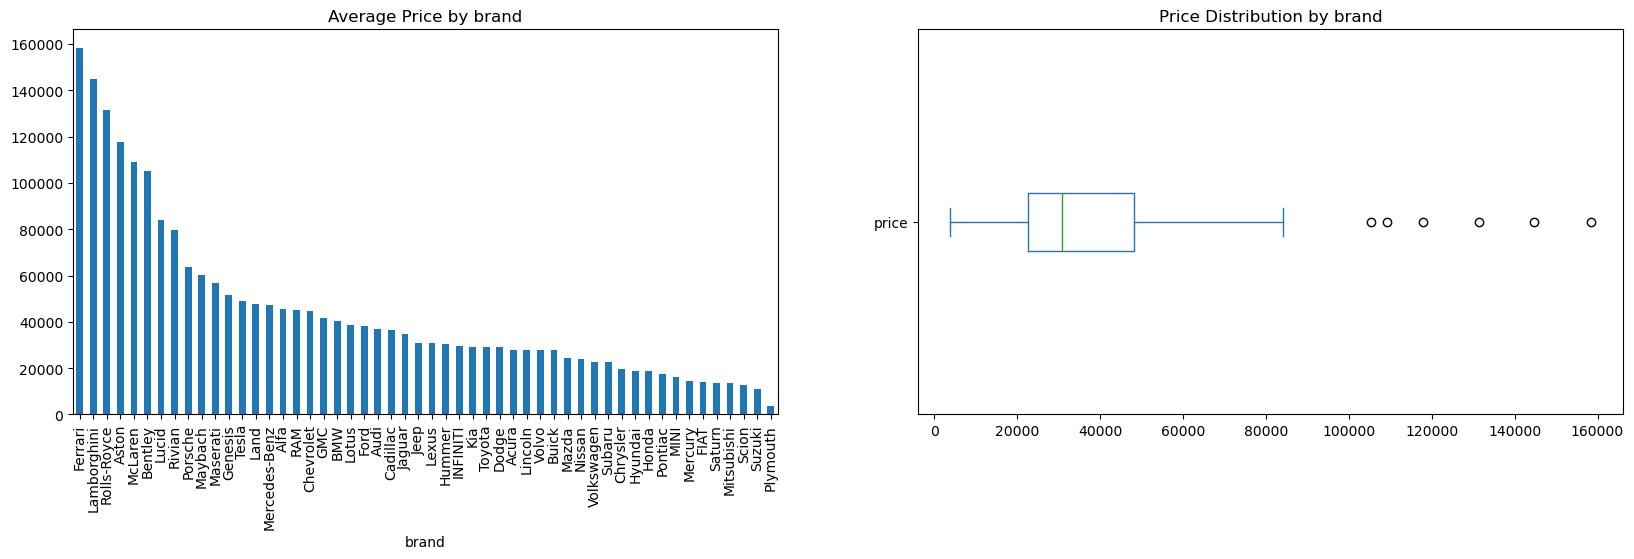

In [1482]:
plt.figure(figsize=(20,5))
# Group data by categorical variable and calculate mean price
price_by_category = df_data.groupby('brand')['price'].mean().sort_values(ascending=False)

plt.subplot(1,2,1)
# Visualize with bar chart
price_by_category[1:].plot(kind='bar')
plt.title('Average Price by brand')

plt.subplot(1,2,2)
# Alternatively, visualize with boxplots
price_by_category[1:].plot(kind='box', vert=False)
plt.title('Price Distribution by brand')
plt.show()


#### Average Milage by Brand

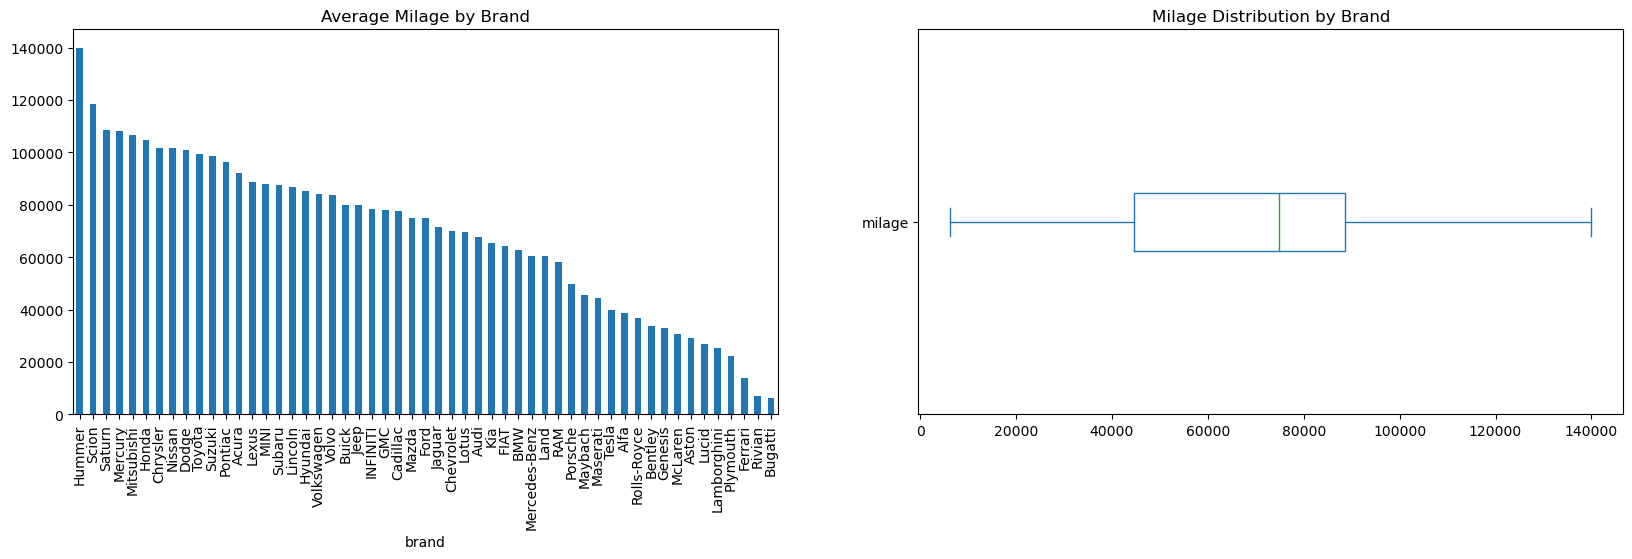

In [1483]:
plt.figure(figsize=(20,5))
# Group data by categorical variable and calculate mean price
milage_by_category = df_data.groupby('brand')['milage'].mean().sort_values(ascending=False)

plt.subplot(1,2,1)
# Visualize with bar chart
# sns.scatterplot(x=price_by_category.keys(), y=price_by_category.values, data=price_by_category)
milage_by_category[:].plot(kind='bar')
plt.title('Average Milage by Brand')

plt.subplot(1,2,2)
# Alternatively, visualize with boxplots
milage_by_category[:].plot(kind='box', vert=False)
plt.title('Milage Distribution by Brand')
plt.show()


#### Price vs Fuel Type

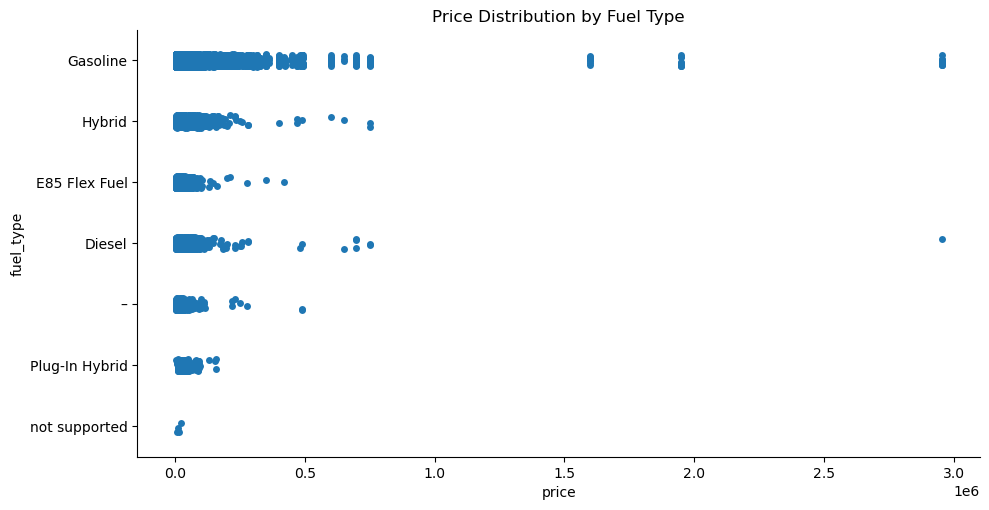

In [1484]:
sns.catplot(data=df_data, x="price", y="fuel_type",  height=5, aspect=2)
plt.title('Price Distribution by Fuel Type')
plt.show()

### Test Baseline machine learning 

In [1485]:
Target = df_data[['price']]

len_df_data = len(df_data)
len_df_test = len(df_test)



In [1486]:
# With outliers
df_ml_one = label_encoder(df_data.iloc[:len_df_data])
df_ml_one['price'] = Target['price']

MachineLearningModels(df_ml_one.drop('price', axis=1), df_ml_one['price'])

Linear Regression RMSE: 69377.14
-----------------------------------
XGBoost RMSE: 73825.93
-----------------------------------


In [1487]:
# Handling outliers
df_ml_one = label_encoder(df_data.iloc[:len_df_data])
df_ml_one['price'] = Target['price']
df_ml_one = impute_outliers_IQR(df_ml_one, ['price','milage', 'model_year'])

MachineLearningModels(df_ml_one.drop('price', axis=1), df_ml_one['price'])

Linear Regression RMSE: 13228.23
-----------------------------------
XGBoost RMSE: 12441.96
-----------------------------------


-  See, handling outliers improves the performance of the base models. 

In [1488]:
# combine train and test data so we can process them together
df_data = pd.concat([df_data.drop('price', axis=1), df_test], axis=0).reset_index(drop=True)

# Feature Engineering

### HorsePower HP

In [1489]:
df_data['engine']

0            375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel
1        300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...
2             300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel
3        335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...
4            200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel
                               ...                        
90451         420.0HP 6.2L 8 Cylinder Engine Gasoline Fuel
90452         295.0HP 5.3L 8 Cylinder Engine Gasoline Fuel
90453         132.0HP 1.8L 4 Cylinder Engine Gasoline Fuel
90454        450.0HP 3.5L V6 Cylinder Engine Gasoline Fuel
90455    320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...
Name: engine, Length: 90456, dtype: object

In [1490]:
df_data['engine'][0]

'375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel'

In [1491]:
# Extract horsepower
df_data['horsepower'] = df_data['engine'].str.extract('(\d+\.\d+)HP').astype(float)

In [1492]:
df_data['horsepower']

0        375.0
1        300.0
2        300.0
3        335.0
4        200.0
         ...  
90451    420.0
90452    295.0
90453    132.0
90454    450.0
90455    320.0
Name: horsepower, Length: 90456, dtype: float64

In [1493]:
df_data['horsepower'].isna().sum()  

6663

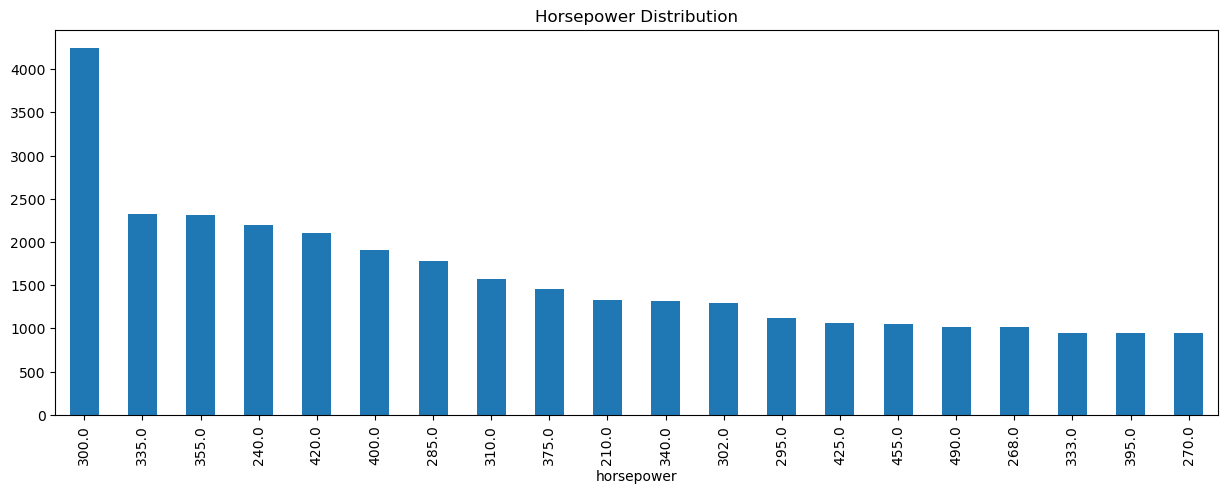

In [1494]:
df_data['horsepower'].value_counts().head(20).plot(kind='bar', figsize=(15,5))  
plt.title('Horsepower Distribution')
plt.show()

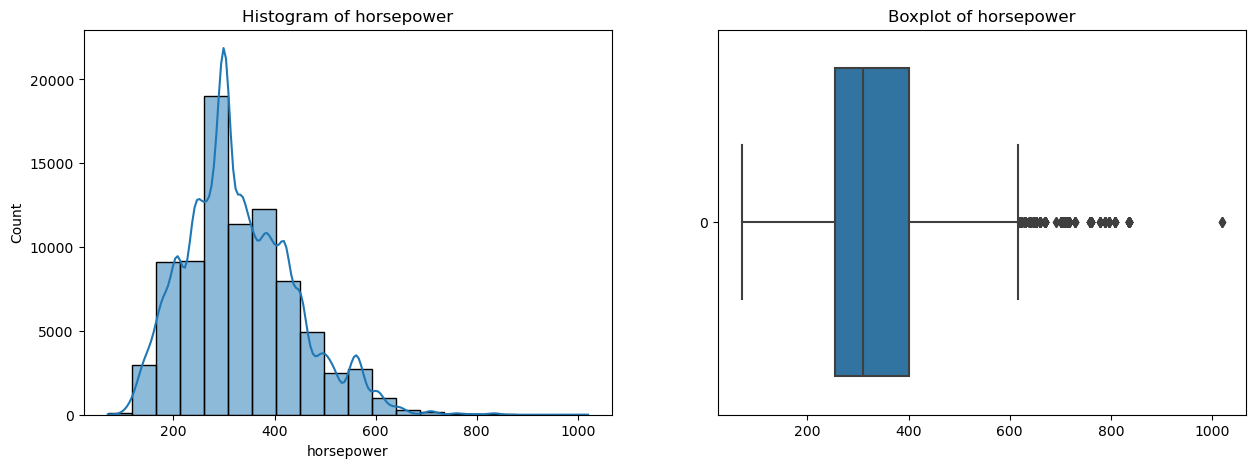

In [1495]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(df_data['horsepower'], bins=20, kde=True)
plt.title('Histogram of horsepower')
plt.subplot(1,2,2)
sns.boxplot(df_data['horsepower'], orient='h')
plt.title('Boxplot of horsepower')
plt.show()

In [1496]:
df_data[df_data['horsepower']==df_data['horsepower'].max()]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,horsepower
19882,Tesla,Model X Plaid,2021,13000,Gasoline,1020.0HP Electric Motor Electric Fuel System,A/T,Black,Black,None reported,1020.0
25873,Tesla,Model X Plaid,2020,73091,Gasoline,1020.0HP Electric Motor Electric Fuel System,A/T,White,Gray,None reported,1020.0
34757,Tesla,Model X Plaid,2021,15500,Gasoline,1020.0HP Electric Motor Electric Fuel System,1-Speed A/T,Silver,Black,None reported,1020.0


In [1497]:
df_data[df_data['horsepower']==df_data['horsepower'].min()]

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,horsepower
83806,smart,ForTwo Pure,2008,61595,Gasoline,70.0HP 1.0L 3 Cylinder Engine Gasoline Fuel,5-Speed M/T,Blue,Beige,None reported,70.0


In [1498]:
df_data.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'horsepower'],
      dtype='object')

### Engine Size: L

In [1499]:
# from the engine column, extract the engine size in litres. The value ends with an L
df_data['engine_size_litres'] = df_data['engine'].str.extract('(\d+\.\d+)L').astype(float)

In [1500]:
df_data['engine_size_litres'].isna().sum()

1011

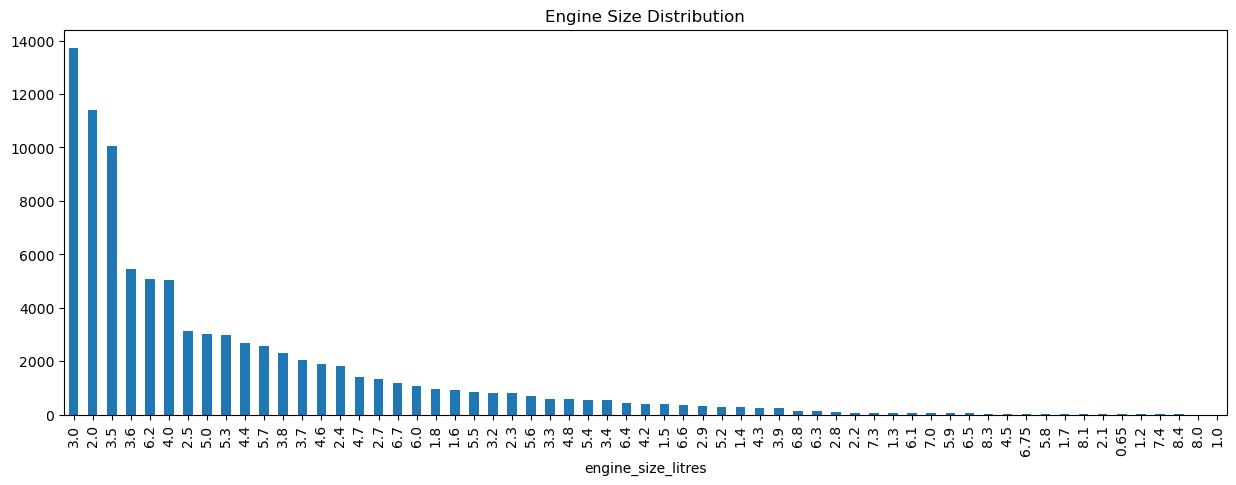

In [1501]:
df_data['engine_size_litres'].value_counts().plot(kind='bar', figsize=(15,5))
plt.title('Engine Size Distribution')
plt.show()

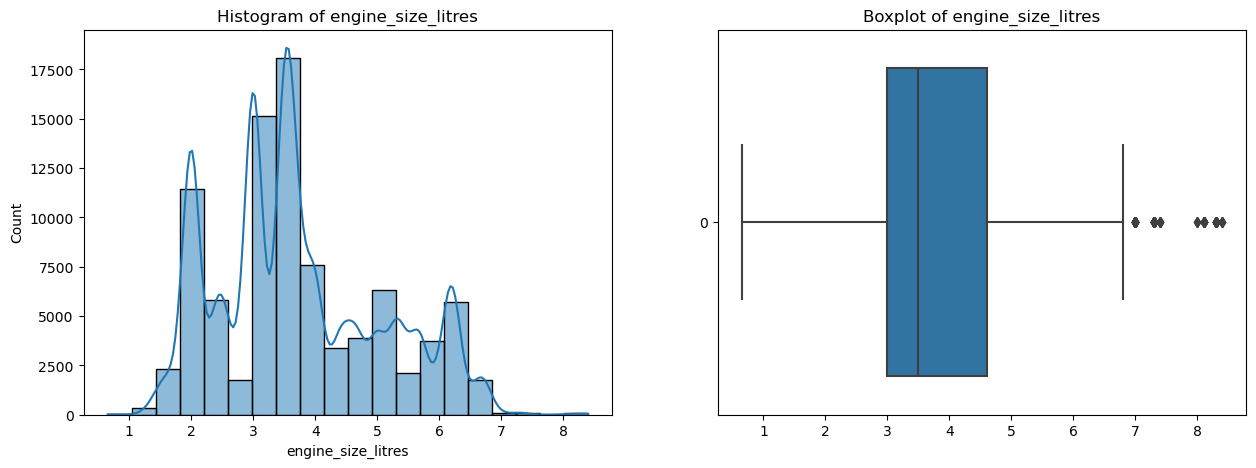

In [1502]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(df_data['engine_size_litres'], bins=20, kde=True)
plt.title('Histogram of engine_size_litres')
plt.subplot(1,2,2)
sns.boxplot(df_data['engine_size_litres'], orient='h')
plt.title('Boxplot of engine_size_litres')
plt.show()

### Engine Cylinders

In [1503]:
df_data['engine'][:10].values

array(['375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel',
       '300.0HP 3.0L Straight 6 Cylinder Engine Gasoline Fuel',
       '300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel',
       '335.0HP 3.0L Straight 6 Cylinder Engine Gasoline/Mild Electric Hybrid',
       '200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel',
       '140.0HP 1.8L 4 Cylinder Engine Gasoline Fuel',
       '333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel',
       '193.0HP 2.5L 4 Cylinder Engine Gasoline Fuel',
       '200.0HP 2.0L 4 Cylinder Engine Gasoline Fuel',
       '300.0HP 3.7L V6 Cylinder Engine Gasoline Fuel'], dtype=object)

In [1504]:
def extract_cylinders(engine_string):
  """
  Extracts the number of cylinders from the engine string, 
  handling formats '(d+) Cylinder' and '(V\d+)'. Returns the original 
  string if no match is found or if the value is missing.
  """
  if pd.isna(engine_string):  # Handle missing values explicitly
    return engine_string
  
  # Try extracting with both cylinder and V-engine formats
  match1 = re.search(r'(\d+) Cylinder', engine_string)
  match2 = re.search(r'(V\d+)', engine_string)
  
  if match1:
    return match1.group(1)  # Extract captured group (cylinder number)
  elif match2:
    return match2.group(1)[1:]  # Extract cylinder number from V-engine format (skip 'V')
  else:
    return np.nan  # Return nan if no match is found

In [1505]:
# Apply the function to the 'engine' column
df_data['engine'].apply(extract_cylinders)

0        6
1        6
2        8
3        6
4        6
        ..
90451    8
90452    8
90453    4
90454    6
90455    8
Name: engine, Length: 90456, dtype: object

In [1506]:
# extract the number of cylinders from the engine column
df_data['engine_cylinders'] = df_data['engine'].apply(extract_cylinders).astype(float)
# Extractr V classes
df_data['engine_v_cylinders'] = df_data['engine'].str.extract('(V\d+)')

df_test['engine_cylinders'] = df_test['engine'].apply(extract_cylinders).astype(float)
# Extractr V classes
df_test['engine_v_cylinders'] = df_test['engine'].str.extract('(V\d+)')

In [1507]:
df_data.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,horsepower,engine_size_litres,engine_cylinders,engine_v_cylinders
0,Ford,F-150 Lariat,2018,74349,Gasoline,375.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,10-Speed A/T,Blue,Gray,None reported,375.0,3.5,6.0,V6
1,BMW,335 i,2007,80000,Gasoline,300.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,6-Speed M/T,Black,Black,None reported,300.0,3.0,6.0,NaN
2,Jaguar,XF Luxury,2009,91491,Gasoline,300.0HP 4.2L 8 Cylinder Engine Gasoline Fuel,6-Speed A/T,Purple,Beige,None reported,300.0,4.2,8.0,NaN
3,BMW,X7 xDrive40i,2022,2437,Hybrid,335.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Gray,Brown,None reported,335.0,3.0,6.0,NaN
4,Pontiac,Firebird Base,2001,111000,Gasoline,200.0HP 3.8L V6 Cylinder Engine Gasoline Fuel,A/T,White,Black,None reported,200.0,3.8,6.0,V6


In [1508]:
df_data['engine_cylinders'].unique()

array([ 6.,  8.,  4., nan,  5., 12., 10.,  3.])

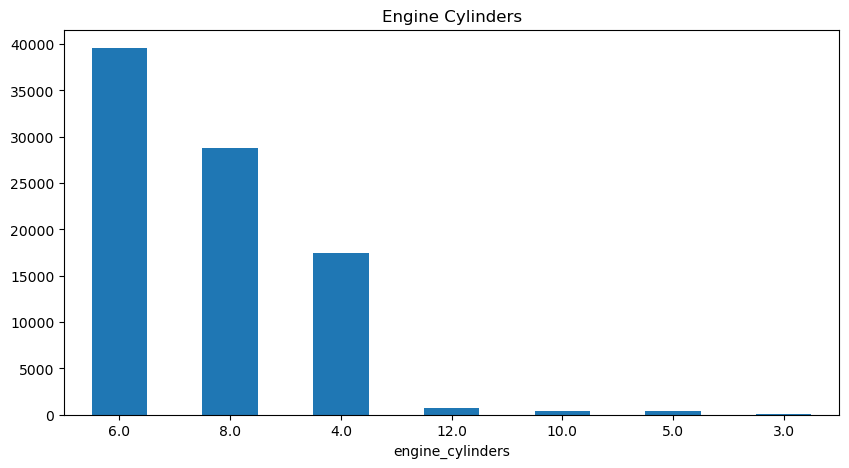

In [1509]:
df_data['engine_cylinders'].value_counts().plot(kind='bar', figsize=(10,5))
plt.xticks(rotation=0)
plt.title('Engine Cylinders')
plt.show()

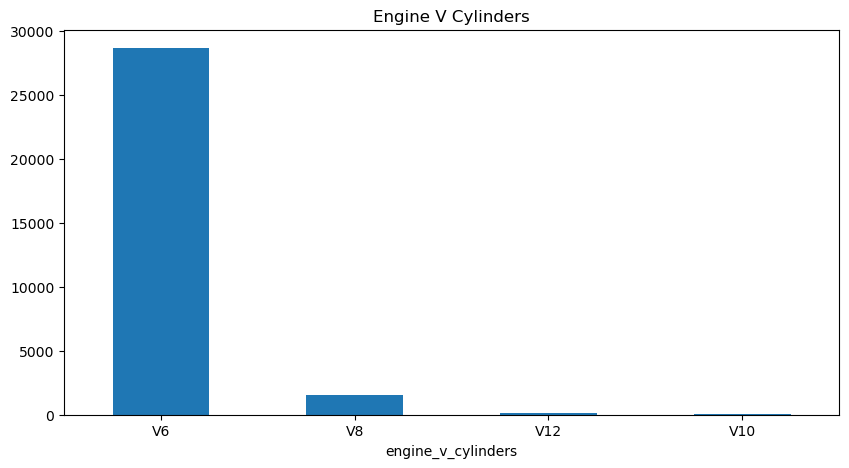

In [1510]:
df_data['engine_v_cylinders'].value_counts().plot(kind='bar', figsize=(10,5))
plt.xticks(rotation=0)
plt.title('Engine V Cylinders')
plt.show()

### TransmissionType

In [1511]:
df_data['transmission'].value_counts(ascending=False)

transmission
A/T                                                   28030
8-Speed A/T                                           12105
Transmission w/Dual Shift Mode                        10720
6-Speed A/T                                            9845
6-Speed M/T                                            6100
7-Speed A/T                                            5631
10-Speed A/T                                           3630
5-Speed A/T                                            2032
8-Speed Automatic                                      1928
9-Speed A/T                                            1761
4-Speed A/T                                            1315
5-Speed M/T                                            1189
CVT Transmission                                       1177
10-Speed Automatic                                     1048
6-Speed Automatic                                       836
Automatic                                               728
M/T                        

In [1512]:
# create a new column called manual_transmission
# if transmission contains ['M/T', 'Manual', 'mt'], set the value to 1, otherwise 0
df_data['manual_transmission'] = df_data['transmission'].apply(lambda x: 1 if 'M/T' in x or 'Manual' in x or 'mt' in x else 0)

<Axes: xlabel='manual_transmission'>

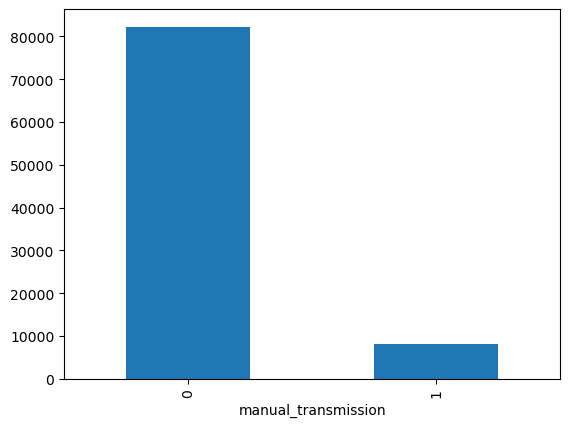

In [1513]:
df_data['manual_transmission'].value_counts().plot(kind='bar')

### Transmission Gears:  Number of gears

In [1514]:
# Extract the transmission number of gears from the transmission column
df_data['transmission_speed_gears'] = df_data['transmission'].str.extract('(\d+)').astype(float)

In [1515]:
# count the nulls in the transmission_speed_gears column
df_data['transmission_speed_gears'].isnull().sum()

41569

In [1516]:
# percentage of nulls in the transmission_speed_gears column
df_data['transmission_speed_gears'].isnull().mean()*100

45.95493941805961

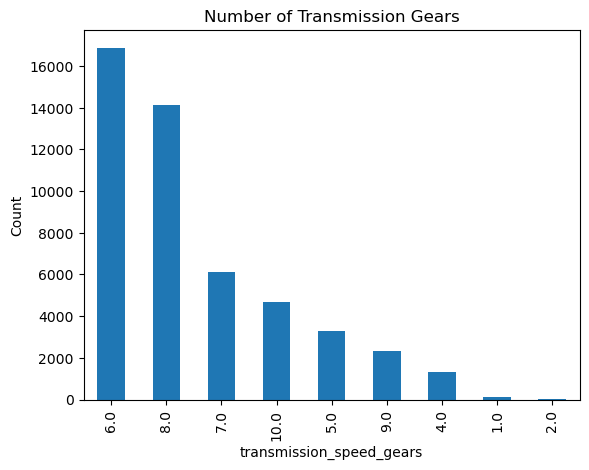

In [1517]:
df_data['transmission_speed_gears'].value_counts().plot(kind='bar', title='Number of Transmission Gears')
plt.ylabel('Count')
plt.show()

### Car Age

In [1518]:
from datetime import date
# get todays date
today = date.today()

# get current year from todays date
current_year = today.year

print('Today:', today)
print('Current year:', current_year)


Today: 2024-06-17
Current year: 2024


In [1519]:
# get car age from model_year vs current year
df_data['car_age'] = current_year - df_data['model_year']

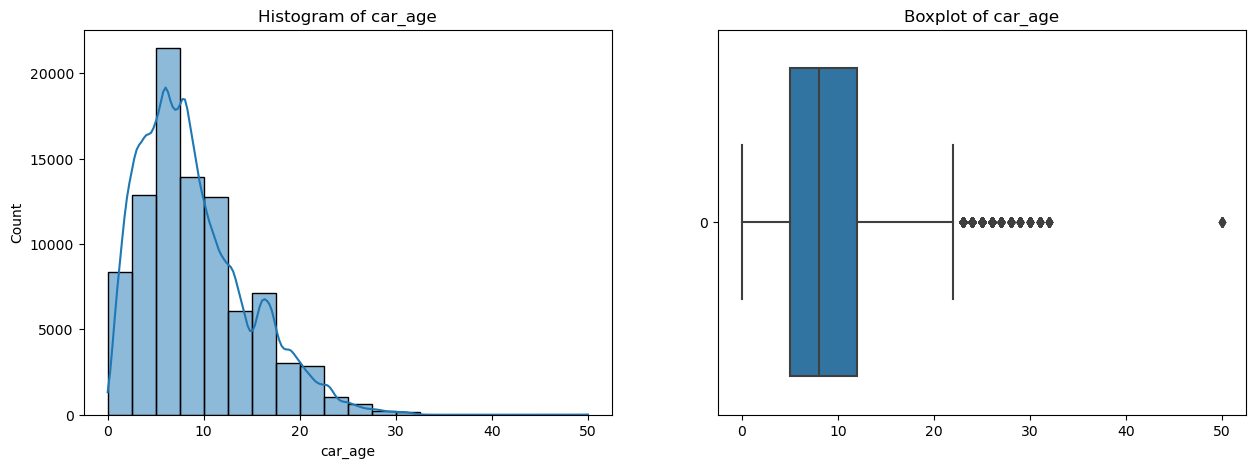

In [1520]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.histplot(df_data['car_age'], bins=20, kde=True)
plt.title('Histogram of car_age')
plt.subplot(1,2,2)
sns.boxplot(df_data['car_age'], orient='h')
plt.title('Boxplot of car_age')
plt.show()

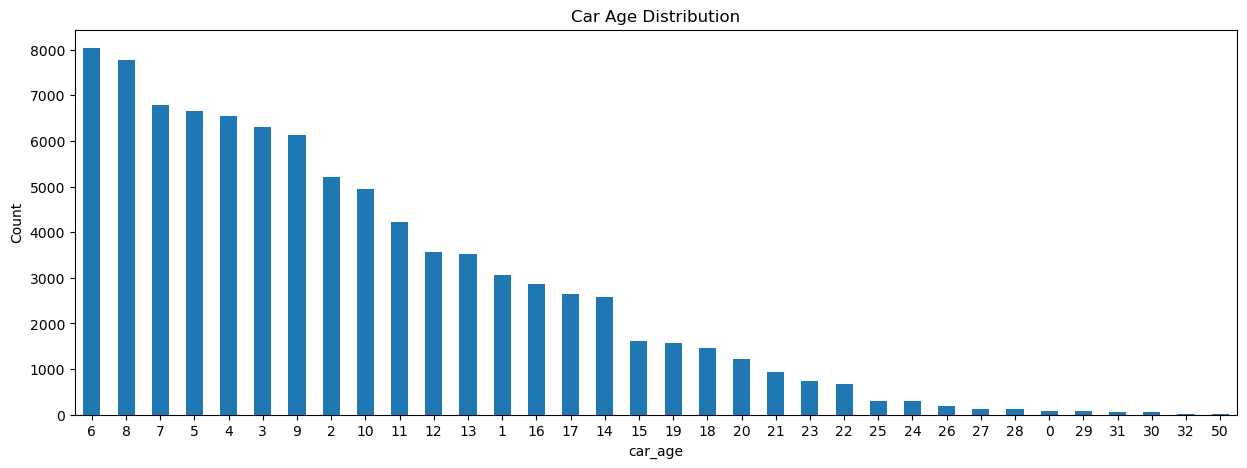

In [1521]:
# plot distribution of car age
df_data['car_age'].value_counts().plot(kind='bar', title='Car Age Distribution', figsize=(15,5))
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.show()

### Int Color

In [1522]:
df_data['int_col'].unique()

array(['Gray', 'Black', 'Beige', 'Brown', 'Silver', 'Jet Black', 'Mesa',
       'White', '–', 'Red', 'Blue', 'Medium Stone', 'Ash', 'Ebony',
       'Shara Beige', 'Tan', 'Titan Black / Quarzit', 'Global Black',
       'Orange', 'Saddle Brown', 'Nero Ade', 'Beluga', 'Light Slate',
       'Gold', 'Black Onyx', 'Nougat Brown', 'Camel', 'Hotspur Hide',
       'Charcoal', 'Satin Black', 'Deep Chestnut', 'Diesel Gray / Black',
       'White / Brown', 'AMG Black', 'Parchment', 'Shale',
       'Canberra Beige', 'Sahara Tan', 'Ebony / Pimento', 'Rhapsody Blue',
       'Medium Dark Slate', 'Rioja Red', 'Black / Express Red',
       'Deep Garnet', 'Portland', 'Sandstone', 'Dark Ash', 'Deep Cypress',
       'Black / Stone Grey', 'Chestnut', 'Navy Pier', 'Green',
       'Giallo Taurus / Nero Ade', 'Mistral Gray / Raven', 'Dark Gray',
       'Amber', 'Charles Blue', 'Hotspur', 'Medium Earth Gray', 'Ceramic',
       'Kyalami Orange', 'Charcoal Black', 'Adrenaline Red', 'Walnut',
       'Brandy', 'Bla

In [1523]:
# from the df_data['int_col'] column, remove the white spaces in words containing /. For example, 'Red / Black' to 'Red/Black'
df_data['int_col'] = df_data['int_col'].str.replace(' / ', '/')

# replace blk with Black
df_data['int_col'] = df_data['int_col'].replace('Blk', 'Black')
# replace BLACK with Black
df_data['int_col'] = df_data['int_col'].replace('BLACK', 'Black')
# convert to lowercase
df_data['int_col'] = df_data['int_col'].str.lower()

# # from the df_test['int_col'] column, remove the white spaces in words containing /. For example, 'Red / Black' to 'Red/Black'
# df_test['int_col'] = df_test['int_col'].str.replace(' / ', '/')
# # replace blk with Black
# df_test['int_col'] = df_test['int_col'].replace('Blk', 'Black')
# # replace BLACK with Black
# df_test['int_col'] = df_test['int_col'].replace('BLACK', 'Black')
# # convert to lowercase
# df_test['int_col'] = df_test['int_col'].str.lower()

In [1524]:
df_data['int_col'].unique()

array(['gray', 'black', 'beige', 'brown', 'silver', 'jet black', 'mesa',
       'white', '–', 'red', 'blue', 'medium stone', 'ash', 'ebony',
       'shara beige', 'tan', 'titan black/quarzit', 'global black',
       'orange', 'saddle brown', 'nero ade', 'beluga', 'light slate',
       'gold', 'black onyx', 'nougat brown', 'camel', 'hotspur hide',
       'charcoal', 'satin black', 'deep chestnut', 'diesel gray/black',
       'white/brown', 'amg black', 'parchment', 'shale', 'canberra beige',
       'sahara tan', 'ebony/pimento', 'rhapsody blue',
       'medium dark slate', 'rioja red', 'black/express red',
       'deep garnet', 'portland', 'sandstone', 'dark ash', 'deep cypress',
       'black/stone grey', 'chestnut', 'navy pier', 'green',
       'giallo taurus/nero ade', 'mistral gray/raven', 'dark gray',
       'amber', 'charles blue', 'hotspur', 'medium earth gray', 'ceramic',
       'kyalami orange', 'charcoal black', 'adrenaline red', 'walnut',
       'brandy', 'black/saddle', 'obs

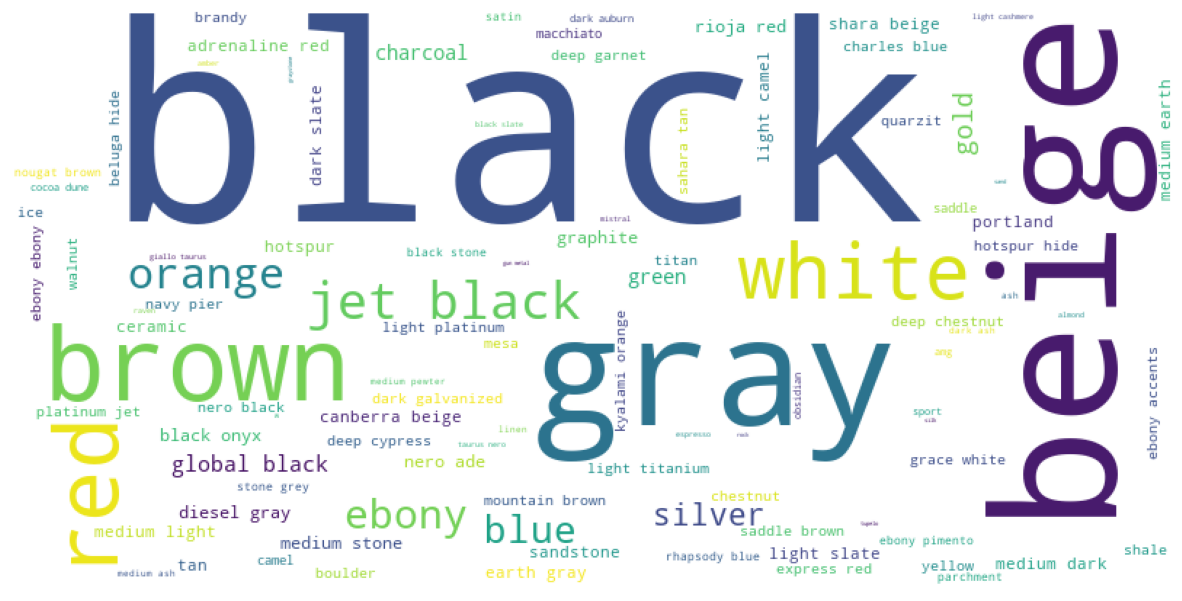

In [1525]:
# let us plot a word cloud of the int_col column
from wordcloud import WordCloud
plt.figure(figsize=(15,10))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df_data['int_col']))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [1526]:
# create a dictionary for these main colors: Black, White, Silver, Blue, Red, Gray, Green, Brown, Gold, Orange, Yellow, Purple, Pink
main_colors = {'Black': ['black', 'blk', 'ebony', 'nero ade'],
                'White': ['white', 'wht', 'platinum', 'ice', 'cloud'],
                'Silver': ['silver', 'sil'],
                'Blue': ['blue', 'blu', 'medium stone', 'navy pier'],
                'Red':  ['red', 'mesa', 'deep chestnut', 'deep garnet', 'boulder', 'tupelo'], 
                'Gray': ['gray', 'gry', 'ash', 'beluga', 'light slate', 'titanium', 'charcoal', 'graystone', 'medium pewter', 'graphite'],
                'Green':   ['green', 'grn'],
                'Brown': ['brown', 'beige','brandy','mocha','caramel','dark galvanized', 'tan','dark auburn','cappuccino','espresso', 'camel','macchiato', 'cinnamon', 'cocoa','chestnut', 'dark khaki', 'dark slate', 'desert sand', 'fawn', 'ginger', 'hazelnut', 'mocha', 'saddle', 'sahara', 'sandstone', 'sepia', 'sienna', 'terra cotta', 'umber', 'walnut'],
                'Orange': ['orange', 'org', 'amber', 'gold'],
                'Yellow': ['yellow', 'yel'],
                'Purple': ['purple', 'pur'],
                'Pink': ['pink', 'pnk'],
                'other': ['other', '–','hotspur', 'hotspur hide', 'shale', 'portland', 'deep cypress', 'ceramic', 'oyster w/contrast', 'slate', 'nero', 'sport','linen', 'parchment', 'cashmere', 'very light cashmere']}



In [1527]:
# get key color from main_colors dictionary using the value
def get_key_color(value):
    for key, color_list in main_colors.items():
        if value in color_list:
            return key
    return 'other'

In [1528]:
get_key_color('ash')

'Gray'

In [1529]:
get_key_color('brandy')

'Brown'

In [1530]:
# lets map the main colors to the int_col column. If any of the keywords in the main_colors dictionary is found in the int_col column, replace it with the key
df_data['main_color'] = df_data['int_col']
for key, values in main_colors.items():
    for color in df_data['int_col'].unique():
        for val in values:
            if val in color:
                df_data.loc[df_data['main_color']==color, 'main_color'] = get_key_color(val)

In [1531]:
df_data['main_color'] .unique()

array(['Gray', 'Black', 'Brown', 'Silver', 'Red', 'White', 'other',
       'Blue', 'Orange', 'Purple', 'Green', 'Yellow', 'anthracite',
       'roast', 'chateau'], dtype=object)

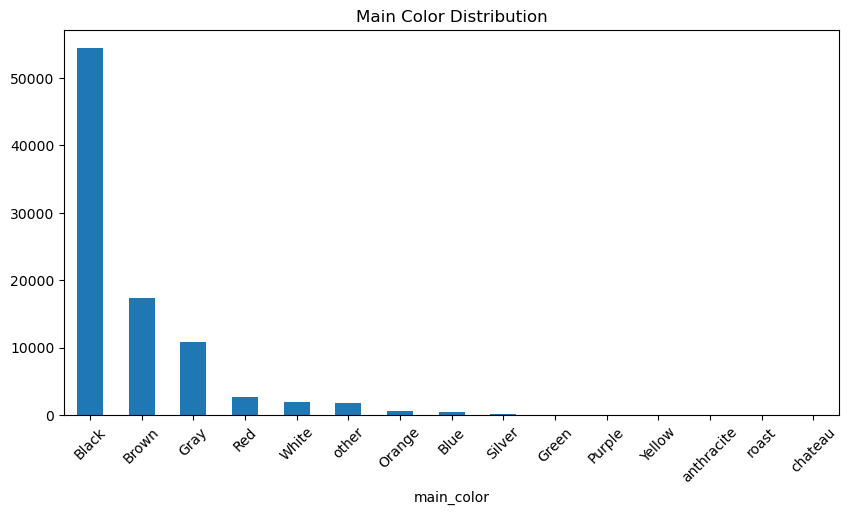

In [1532]:
df_data['main_color'] .value_counts().plot(kind='bar', figsize=(10,5))
plt.xticks(rotation=45)
plt.title('Main Color Distribution')
plt.show()

In [1533]:
# Reduce the numbe of main colors to only the top 8 colors
df_data['main_color'] = df_data['main_color'].apply(lambda x: x if x in ['Black', 'Brown', 'Gray', 'Red', 'White', 'Orange', 'Blue', 'Silver'] else 'other')

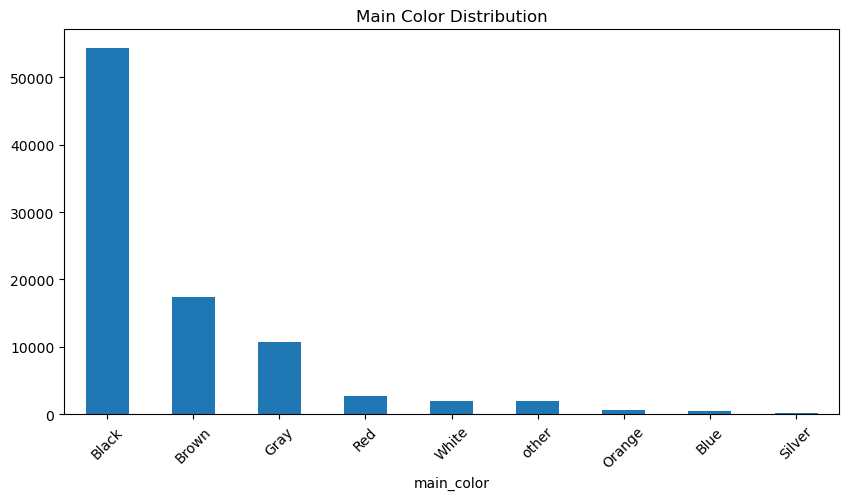

In [1534]:
df_data['main_color'] .value_counts().plot(kind='bar', figsize=(10,5))
plt.xticks(rotation=45)
plt.title('Main Color Distribution')
plt.show()

### Fuel Type:

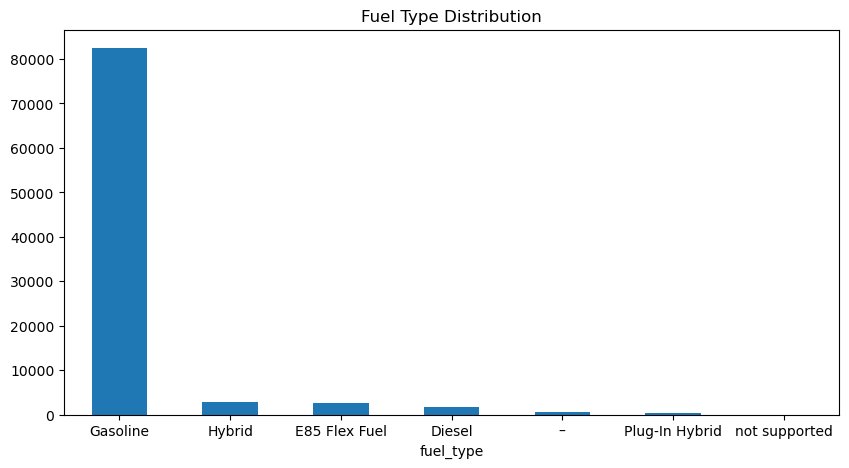

In [1535]:
df_data['fuel_type'].value_counts().plot(kind='bar', figsize=(10,5))
plt.xticks(rotation=0)
plt.title('Fuel Type Distribution')
plt.show()

In [1536]:
fuel_type_mapping = {
  'Gasoline': 'Gasoline',
  'E85 Flex Fuel': 'Gasoline',  # Include E85 Flex Fuel under Gasoline
  'Diesel': 'Diesel',
  'Hybrid Electric': 'Hybrid',
  'Plug-In Hybrid': 'Hybrid' # Include Plug-In Hybrid under Hybrid
}

In [1537]:
df_data['fuel_type'] = df_data['fuel_type'].replace(fuel_type_mapping)
# Handle remaining cases using lambda
df_data['fuel_type'] = df_data['fuel_type'].apply(lambda x: 'Other' if x not in fuel_type_mapping.values() else x)

In [1538]:
df_data['fuel_type'].unique()

array(['Gasoline', 'Hybrid', 'Diesel', 'Other'], dtype=object)

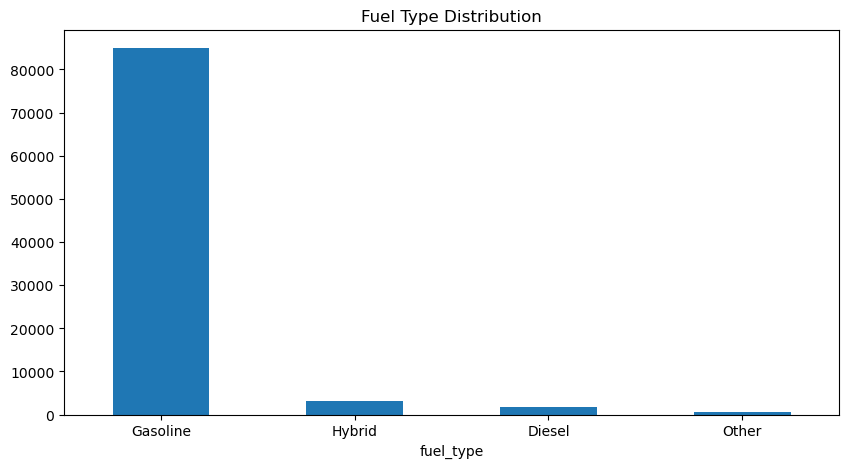

In [1539]:
df_data['fuel_type'].value_counts().plot(kind='bar', figsize=(10,5))
plt.xticks(rotation=0)
plt.title('Fuel Type Distribution')
plt.show()

### Accident:

In [1540]:
df_data['accident'].unique()

array(['None reported', 'At least 1 accident or damage reported'],
      dtype=object)

In [1541]:
# convert accident column to binary. If the value is 'None reported', set to 0, else 1
df_data['accident'] = df_data['accident'].apply(lambda x: 0 if 'None reported' in x else 1)

<Axes: xlabel='accident'>

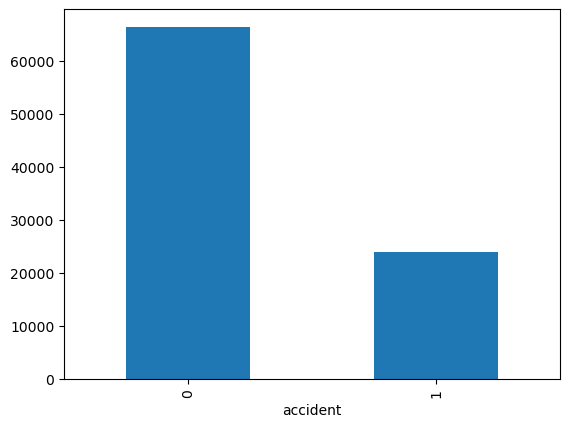

In [1542]:
df_data['accident'].value_counts().plot(kind='bar')

In [1543]:
df_data.dtypes

brand                        object
model                        object
model_year                    int64
milage                        int64
fuel_type                    object
engine                       object
transmission                 object
ext_col                      object
int_col                      object
accident                      int64
horsepower                  float64
engine_size_litres          float64
engine_cylinders            float64
engine_v_cylinders           object
manual_transmission           int64
transmission_speed_gears    float64
car_age                       int64
main_color                   object
dtype: object

In [1544]:
df_data.isna().sum()

brand                           0
model                           0
model_year                      0
milage                          0
fuel_type                       0
engine                          0
transmission                    0
ext_col                         0
int_col                         0
accident                        0
horsepower                   6663
engine_size_litres           1011
engine_cylinders             3134
engine_v_cylinders          60158
manual_transmission             0
transmission_speed_gears    41569
car_age                         0
main_color                      0
dtype: int64

### Test the Baseline models:

In [1545]:
# using KNN imputer with label encoder
df_ml_one = label_encoder(df_data.iloc[:len_df_data])
df_ml_one['price'] = Target 
# apply knn imputer for the rest of the missing values
df_ml_one = knn_impute(df_ml_one)
# impute outliers in numerical variables
df_ml_one = impute_outliers_IQR(df_ml_one, ['price','horsepower', 'milage', 'model_year'])

MachineLearningModels(df_ml_one.drop(['price'], axis=1), df_ml_one['price']) 

Linear Regression RMSE: 13060.24
-----------------------------------
XGBoost RMSE: 12443.62
-----------------------------------


In [1546]:
# use mean_mode_imputer with label encoder
df_ml_one = label_encoder(df_data.iloc[:len_df_data])
df_ml_one['price'] = Target 
df_ml_one = mean_mode_imputer(df_ml_one)
df_ml_one = impute_outliers_IQR(df_ml_one, ['price','horsepower', 'milage', 'model_year'])

MachineLearningModels(df_ml_one.drop(['price'], axis=1), df_ml_one['price'])

Linear Regression RMSE: 13067.42
-----------------------------------
XGBoost RMSE: 12422.46
-----------------------------------


-  For LinearRegression, KNNImputer provides slightly better results than MeanModeImputer.
-  For XGBoost, MeanModeImputer provides slightly better results than KNNImputer.

## Create a new DataFrame: Imputed Data

In [1547]:
imputed_data = df_data.copy()

In [1548]:
imputed_data.isna().sum()

brand                           0
model                           0
model_year                      0
milage                          0
fuel_type                       0
engine                          0
transmission                    0
ext_col                         0
int_col                         0
accident                        0
horsepower                   6663
engine_size_litres           1011
engine_cylinders             3134
engine_v_cylinders          60158
manual_transmission             0
transmission_speed_gears    41569
car_age                         0
main_color                      0
dtype: int64

In [1549]:
# use mean_mode_imputer to impute the missing values in the data
imputed_data = mean_mode_imputer(imputed_data)

In [1550]:
# impute outliers to numerical columns
imputed_data = impute_outliers_IQR(imputed_data, ['horsepower','engine_size_litres','transmission_speed_gears', 'milage', 'model_year', 'car_age'])

In [1551]:
imputed_data.isna().sum()

brand                       0
model                       0
model_year                  0
milage                      0
fuel_type                   0
engine                      0
transmission                0
ext_col                     0
int_col                     0
accident                    0
horsepower                  0
engine_size_litres          0
engine_cylinders            0
engine_v_cylinders          0
manual_transmission         0
transmission_speed_gears    0
car_age                     0
main_color                  0
dtype: int64

## Correlation

Text(0.5, 1.0, 'Correlation Matrix')

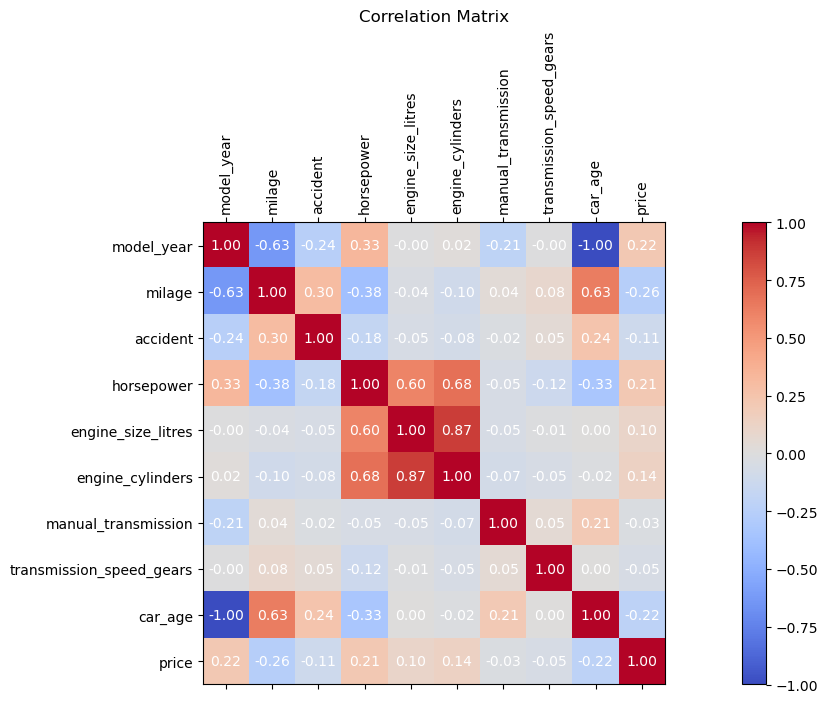

In [1552]:
# Select numeric columns (exclude object columns)
df_corr = imputed_data.iloc[:len_df_data]
df_corr['price'] = Target
numeric_columns = df_corr.select_dtypes(exclude=['category', 'object'])

# Calculate the correlation matrix
corr_matrix = numeric_columns.corr()

# Create a figure and axis
fig, ax = plt.subplots(figsize=(20, 6))

# Create a heatmap with annotated values
cax = ax.matshow(corr_matrix, cmap='coolwarm')
plt.colorbar(cax)

# Display correlation values inside the boxes
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        text = ax.text(j, i, f"{corr_matrix.iloc[i, j]:.2f}", ha="center", va="center", color="w")

# Set ticks and labels
plt.xticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns)
# Set title
plt.title('Correlation Matrix')

## Binning

#### Binning: Horsepower

In [1553]:
# lets bin horsepower. Categorical Bins: based on these 4 categories, Low Power (<150 HP), Medium Power (150-250 HP), High Power (250-400 HP), Very High Power (>400 HP)
bins= [0,150,250,400,1050]
labels = ['Low Power (<150 HP)', 'Medium Power (150-250 HP)', 'High Power (250-400 HP)', 'Very High Power (>400 HP)']
imputed_data['horsepower_categories'] = pd.cut(imputed_data['horsepower'], bins=bins, labels=labels)

In [1554]:
imputed_data.isna().sum()

brand                       0
model                       0
model_year                  0
milage                      0
fuel_type                   0
engine                      0
transmission                0
ext_col                     0
int_col                     0
accident                    0
horsepower                  0
engine_size_litres          0
engine_cylinders            0
engine_v_cylinders          0
manual_transmission         0
transmission_speed_gears    0
car_age                     0
main_color                  0
horsepower_categories       0
dtype: int64

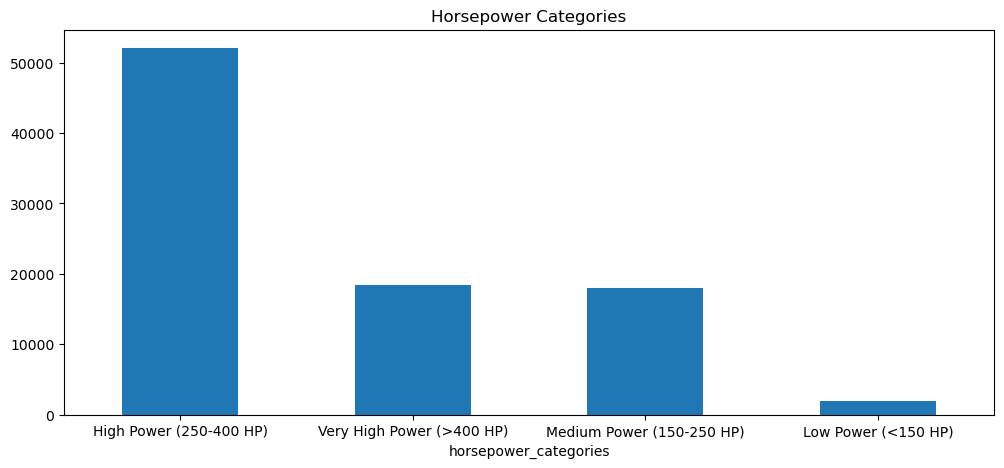

In [1555]:
imputed_data['horsepower_categories'].value_counts().plot(kind='bar', figsize=(12,5))
plt.title('Horsepower Categories')
plt.xticks(rotation=0)
plt.show()

#### Binning: Engine Size

In [1556]:
# lets bin engine size in litres. Categorical Bins: based on these 4 categories, Small Engine (<2.0L), Medium Engine (2.0-4.0L), Large Engine (>4.0L) 
bins= [0,2,4,10]
labels = ['Small Engine (<2.0L)', 'Medium Engine (2.0-4.0L)', 'Large Engine (>4.0L)']
imputed_data['engine_size_categories'] = pd.cut(imputed_data['engine_size_litres'], bins=bins, labels=labels)

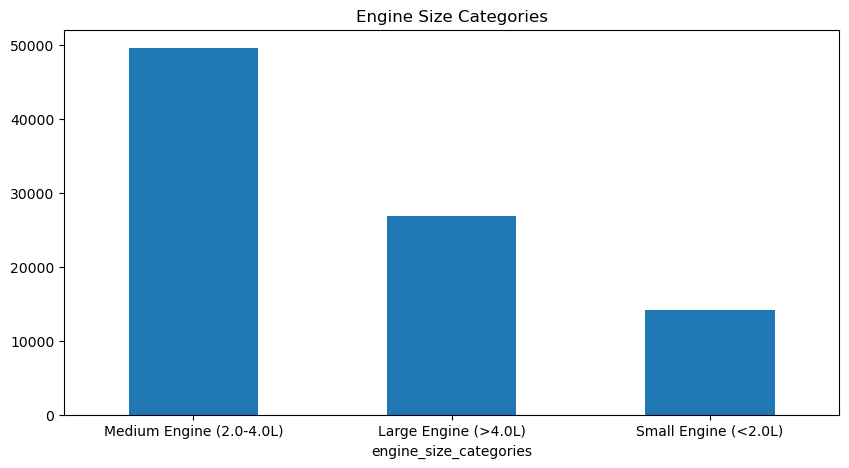

In [1557]:
imputed_data['engine_size_categories'].value_counts().plot(kind='bar', figsize=(10,5))
plt.title('Engine Size Categories')
plt.xticks(rotation=0)
plt.show()

#### Binning: Milage

In [1558]:
# create milage bins. Categorical Bins: based on these 4 categories, Low Mileage (<50000), Medium Mileage (50000-100000), High Mileage (100000-150000), Very High Mileage (>150000)
bins= [0,50000,100000,150000,1000000]
labels = ['Low Mileage (<50k)', 'Medium Mileage (50k-100k)', 'High Mileage (100k-150k)', 'Very High Mileage (>150k)']
imputed_data['milage_categories'] = pd.cut(imputed_data['milage'], bins=bins, labels=labels)


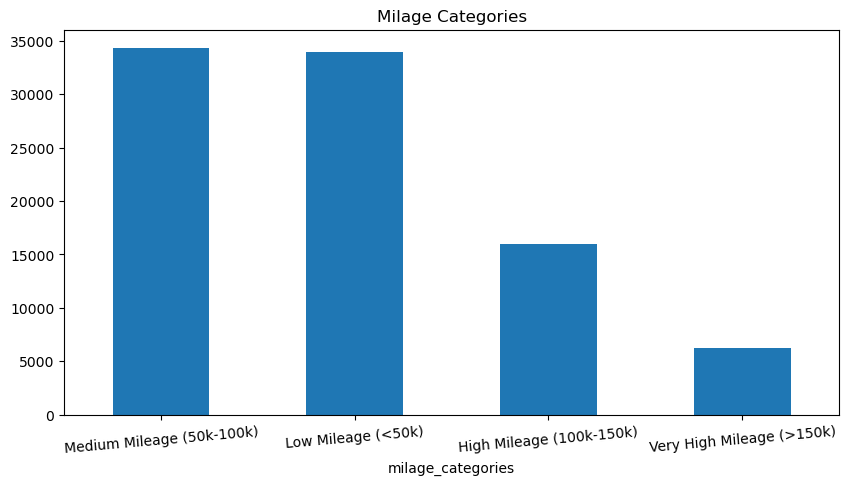

In [1559]:
imputed_data['milage_categories'].value_counts().plot(kind='bar', figsize=(10,5))
plt.title('Milage Categories')
plt.xticks(rotation=5);

### Binning: Car Age

In [1560]:
# create Categorical Bins: based on car lifecycle stages (e.g., Brand New (0-2 years), Slightly Used (3-5 years), Mid-Life (6-10 years), Well-Used (11-15 years), Very Used (>15 years)
bins = [-np.inf, 2, 5, 10, 15, np.inf]
labels = ['Brand New (0-2 years)', 'Slightly Used (3-5 years)', 'Mid-Life (6-10 years)', 'Well-Used (11-15 years)', 'Very Used (>15 years)']
imputed_data['car_age_category'] = pd.cut(imputed_data['car_age'], bins=bins, labels=labels)


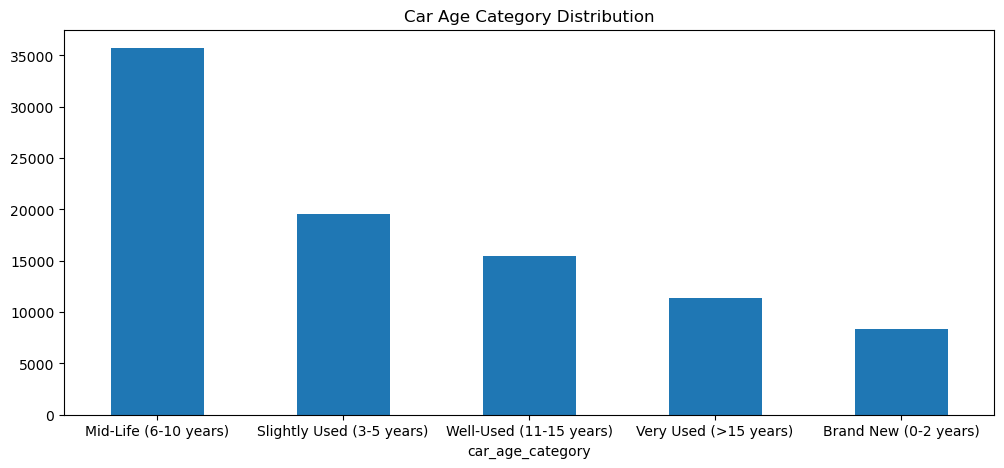

In [1561]:
# plot distribution of car age category
imputed_data['car_age_category'].value_counts().plot(kind='bar', figsize=(12,5), title='Car Age Category Distribution')
plt.xticks(rotation=0)
plt.show()

### Car Age vs Milage features

In [1562]:
imputed_data['average_mileage_per_year'] = imputed_data['milage']/imputed_data['car_age']

imputed_data['average_mileage_per_year'] = imputed_data['average_mileage_per_year'].apply(lambda x: 0 if x == np.inf else x)

# impute outliers
imputed_data = impute_outliers_IQR(imputed_data, ['average_mileage_per_year'])

## Additional Features

In [1563]:
imputed_data['average_mileage_by_engine_size'] = imputed_data['milage']/imputed_data['engine_size_litres']
imputed_data['average_mileage_by_engine_cylinders'] = imputed_data['milage']/imputed_data['engine_cylinders']
imputed_data['average_mileage_by_engine_gears'] = imputed_data['milage']/imputed_data['transmission_speed_gears']
imputed_data['average_mileage_by_horsepower'] = imputed_data['milage']/imputed_data['horsepower']
imputed_data['horsepower_by_engine_size'] = imputed_data['horsepower']/imputed_data['engine_size_litres']
imputed_data['horsepower_by_engine_cylinders'] = imputed_data['horsepower']/imputed_data['engine_cylinders']
imputed_data['horsepower_by_engine_gears'] = imputed_data['horsepower']/imputed_data['transmission_speed_gears']


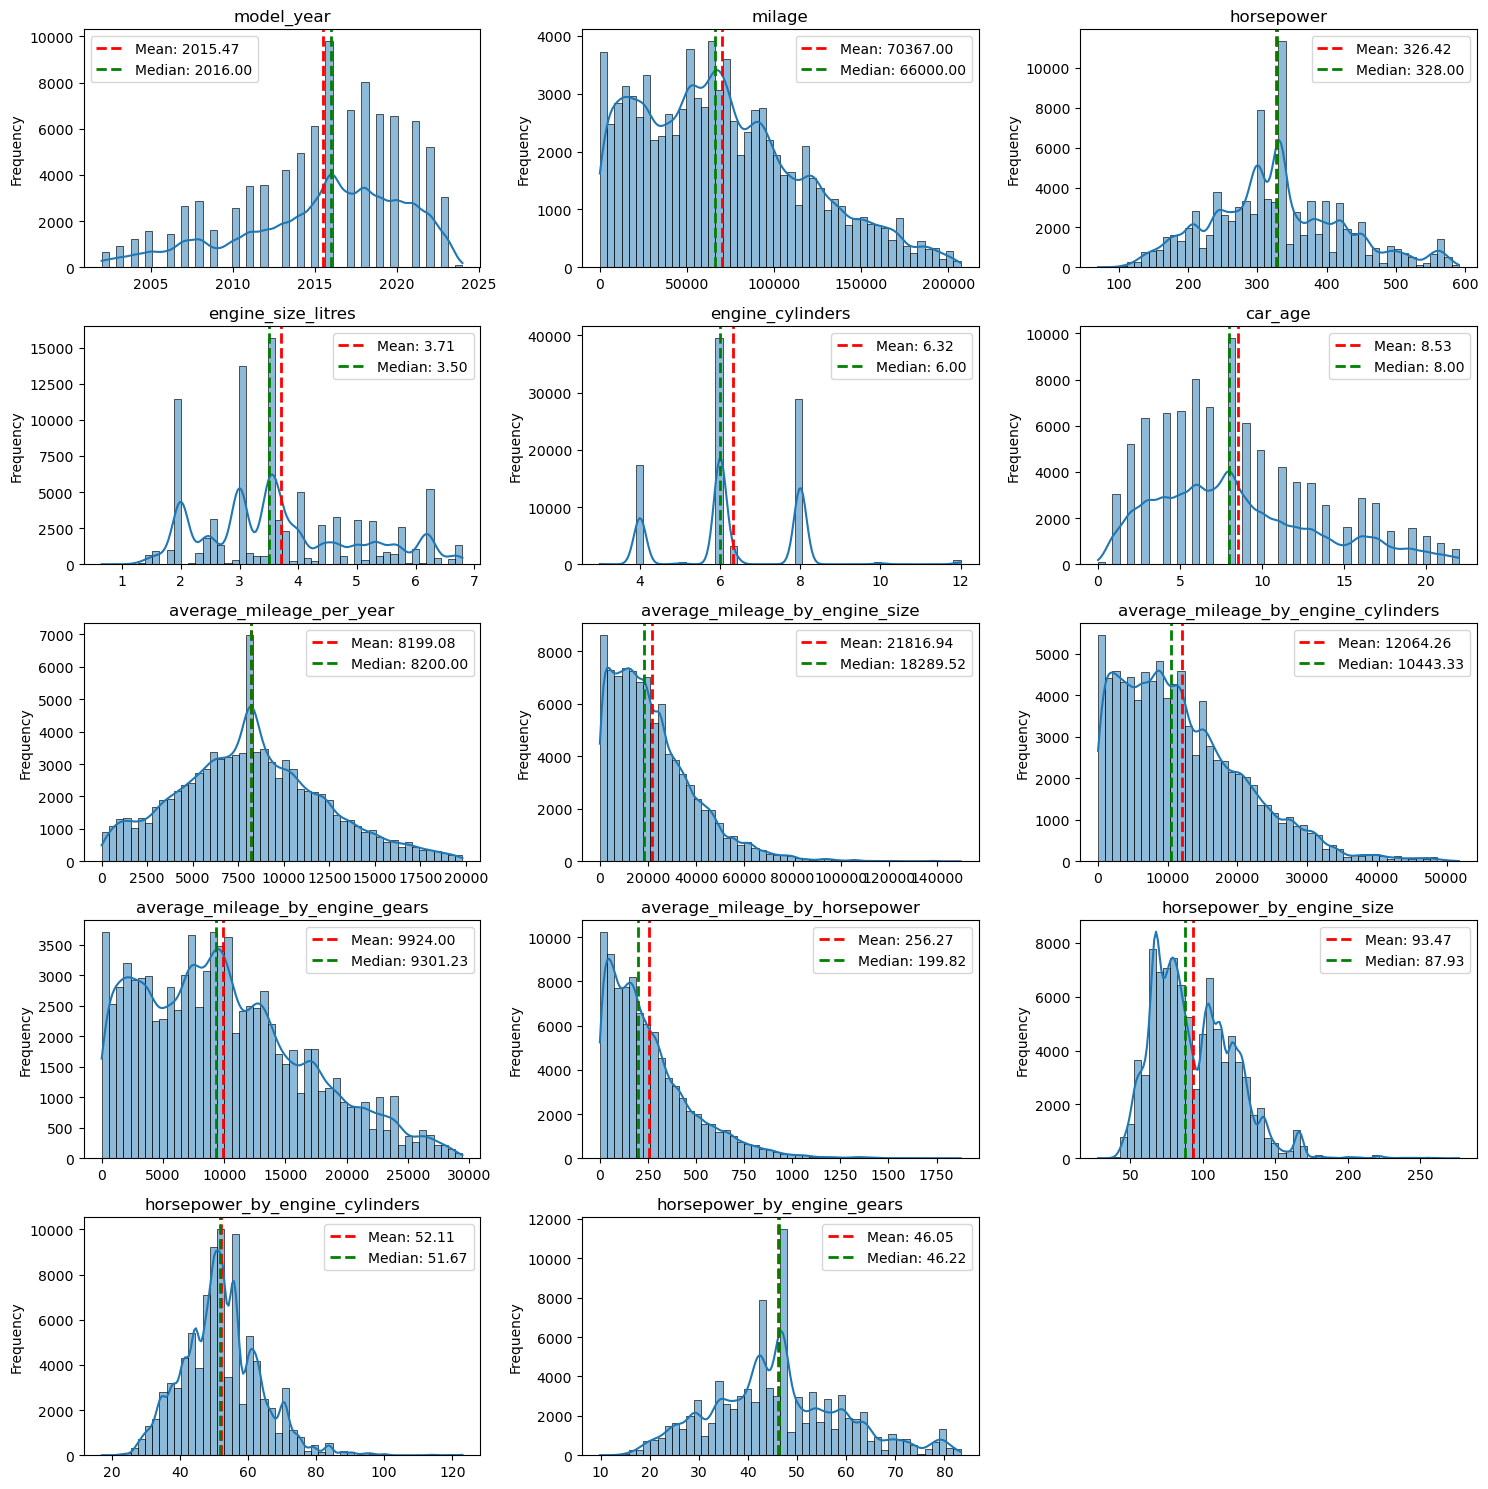

In [1564]:
plot_numerical_features_grid(imputed_data, ncols=3, figsize=(15, 15))

In [1565]:
imputed_data = imputed_data.round(2)

### Update Engine and Transmission

In [1566]:
# if manual_transmission is 1, return Manual, else Automatic
imputed_data['transmission_speed_gears'].round(0).astype(str) + '-Speed ' + imputed_data['manual_transmission'].apply(lambda x: 'Manual' if x == 1 else 'Automatic')

0        7.0-Speed Automatic
1           7.0-Speed Manual
2        7.0-Speed Automatic
3        7.0-Speed Automatic
4        7.0-Speed Automatic
                ...         
90451    7.0-Speed Automatic
90452    7.0-Speed Automatic
90453       7.0-Speed Manual
90454    7.0-Speed Automatic
90455    7.0-Speed Automatic
Length: 90456, dtype: object

In [1567]:
# update the engine column with the new values
imputed_data['engine'] = imputed_data['horsepower'].astype(str) + 'HP ' + imputed_data['engine_size_litres'].astype(str) + 'L ' + imputed_data['engine_cylinders'].astype(str) + ' Cylinder '

# Update the transmission column with the new values
imputed_data['transmission'] = imputed_data['transmission_speed_gears'].round(0).astype(str) + '-Speed ' + imputed_data['manual_transmission'].apply(lambda x: 'Manual' if x == 1 else 'Automatic')


In [1568]:
imputed_data.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,horsepower,engine_size_litres,engine_cylinders,engine_v_cylinders,manual_transmission,transmission_speed_gears,car_age,main_color,horsepower_categories,engine_size_categories,milage_categories,car_age_category,average_mileage_per_year,average_mileage_by_engine_size,average_mileage_by_engine_cylinders,average_mileage_by_engine_gears,average_mileage_by_horsepower,horsepower_by_engine_size,horsepower_by_engine_cylinders,horsepower_by_engine_gears
0,Ford,F-150 Lariat,2018,74349,Gasoline,375.0HP 3.5L 6.0 Cylinder,7.0-Speed Automatic,Blue,gray,0,375.0,3.5,6.0,V6,0,7.1,6,Gray,High Power (250-400 HP),Medium Engine (2.0-4.0L),Medium Mileage (50k-100k),Mid-Life (6-10 years),12391.50,21242.57,12391.50,10477.84,198.26,107.14,62.50,52.85
1,BMW,335 i,2007,80000,Gasoline,300.0HP 3.0L 6.0 Cylinder,7.0-Speed Manual,Black,black,0,300.0,3.0,6.0,V6,1,7.1,17,Black,High Power (250-400 HP),Medium Engine (2.0-4.0L),Medium Mileage (50k-100k),Very Used (>15 years),4705.88,26666.67,13333.33,11274.22,266.67,100.00,50.00,42.28
2,Jaguar,XF Luxury,2009,91491,Gasoline,300.0HP 4.2L 8.0 Cylinder,7.0-Speed Automatic,Purple,beige,0,300.0,4.2,8.0,V6,0,7.1,15,Brown,High Power (250-400 HP),Large Engine (>4.0L),Medium Mileage (50k-100k),Well-Used (11-15 years),6099.40,21783.57,11436.38,12893.62,304.97,71.43,37.50,42.28
3,BMW,X7 xDrive40i,2022,2437,Hybrid,335.0HP 3.0L 6.0 Cylinder,7.0-Speed Automatic,Gray,brown,0,335.0,3.0,6.0,V6,0,7.1,2,Brown,High Power (250-400 HP),Medium Engine (2.0-4.0L),Low Mileage (<50k),Brand New (0-2 years),1218.50,812.33,406.17,343.44,7.27,111.67,55.83,47.21
4,Pontiac,Firebird Base,2016,111000,Gasoline,200.0HP 3.8L 6.0 Cylinder,7.0-Speed Automatic,White,black,0,200.0,3.8,6.0,V6,0,7.1,8,Black,Medium Power (150-250 HP),Medium Engine (2.0-4.0L),High Mileage (100k-150k),Mid-Life (6-10 years),13875.00,29210.53,18500.00,15642.98,555.00,52.63,33.33,28.19


### Brand - Model

In [1569]:
imputed_data['brand_model'] = imputed_data['brand'] + '-' + imputed_data['model']

### Test the Baseline models:

In [1570]:
# get all categorical variables
categorical_columns = imputed_data.select_dtypes(include=['category', 'object']).columns
print(categorical_columns)

Index(['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col',
       'int_col', 'engine_v_cylinders', 'main_color', 'horsepower_categories',
       'engine_size_categories', 'milage_categories', 'car_age_category',
       'brand_model'],
      dtype='object')


In [1571]:
df_ml_one = label_encoder(imputed_data.iloc[:len_df_data])
df_ml_one['price'] = Target 
df_ml_one = impute_outliers_IQR(df_ml_one, ['price'])
MachineLearningModels(df_ml_one.drop(['price'], axis=1), df_ml_one['price'])

Linear Regression RMSE: 13108.36
-----------------------------------
XGBoost RMSE: 12512.15
-----------------------------------


In [1572]:
df_ml_one = label_encoder(imputed_data.iloc[:len_df_data])
df_ml_one['price'] = Target
new_cols =  one_hot_encoder(df_ml_one[['fuel_type','horsepower_categories', 'engine_size_categories', 'milage_categories', 'car_age_category']])
df_ml_one = pd.concat([df_ml_one, new_cols], axis=1)
df_ml_one = impute_outliers_IQR(df_ml_one, ['price'])

MachineLearningModels(df_ml_one.drop(['price'], axis=1), df_ml_one['price'])

Linear Regression RMSE: 13107.65
-----------------------------------
XGBoost RMSE: 12512.15
-----------------------------------


In [1573]:
df_ml_one = imputed_data.iloc[:len_df_data]
df_ml_one['price'] = Target
new_cols =  one_hot_encoder(df_ml_one[['horsepower_categories', 'engine_size_categories', 'milage_categories', 'car_age_category']])
df_ml_one = pd.concat([df_ml_one, new_cols], axis=1)
df_ml_one = label_encoder(df_ml_one)
df_ml_one = impute_outliers_IQR(df_ml_one, ['price','horsepower', 'milage', 'model_year', 'average_mileage_by_engine_size', 'average_mileage_by_engine_cylinders', 'average_mileage_by_engine_gears', 'average_mileage_by_horsepower', 'horsepower_by_engine_size', 'horsepower_by_engine_cylinders', 'horsepower_by_engine_gears'])

MachineLearningModels(df_ml_one.drop(['brand_model','model_year','ext_col','int_col','engine_v_cylinders','price'], axis=1), df_ml_one['price'])

Linear Regression RMSE: 12949.6
-----------------------------------
XGBoost RMSE: 12498.88
-----------------------------------


## XGBoost Feature Importance

In [ ]:
df_ml_one = imputed_data.iloc[:len_df_data]
df_ml_one['price'] = Target
new_cols =  one_hot_encoder(df_ml_one[['horsepower_categories', 'engine_size_categories', 'milage_categories', 'car_age_category']])
df_ml_one = pd.concat([df_ml_one, new_cols], axis=1)
df_ml_one = label_encoder(df_ml_one)
df_ml_one = impute_outliers_IQR(df_ml_one, ['price','horsepower', 'milage', 'model_year', 'average_mileage_by_engine_size', 'average_mileage_by_engine_cylinders', 'average_mileage_by_engine_gears', 'average_mileage_by_horsepower', 'horsepower_by_engine_size', 'horsepower_by_engine_cylinders', 'horsepower_by_engine_gears'])


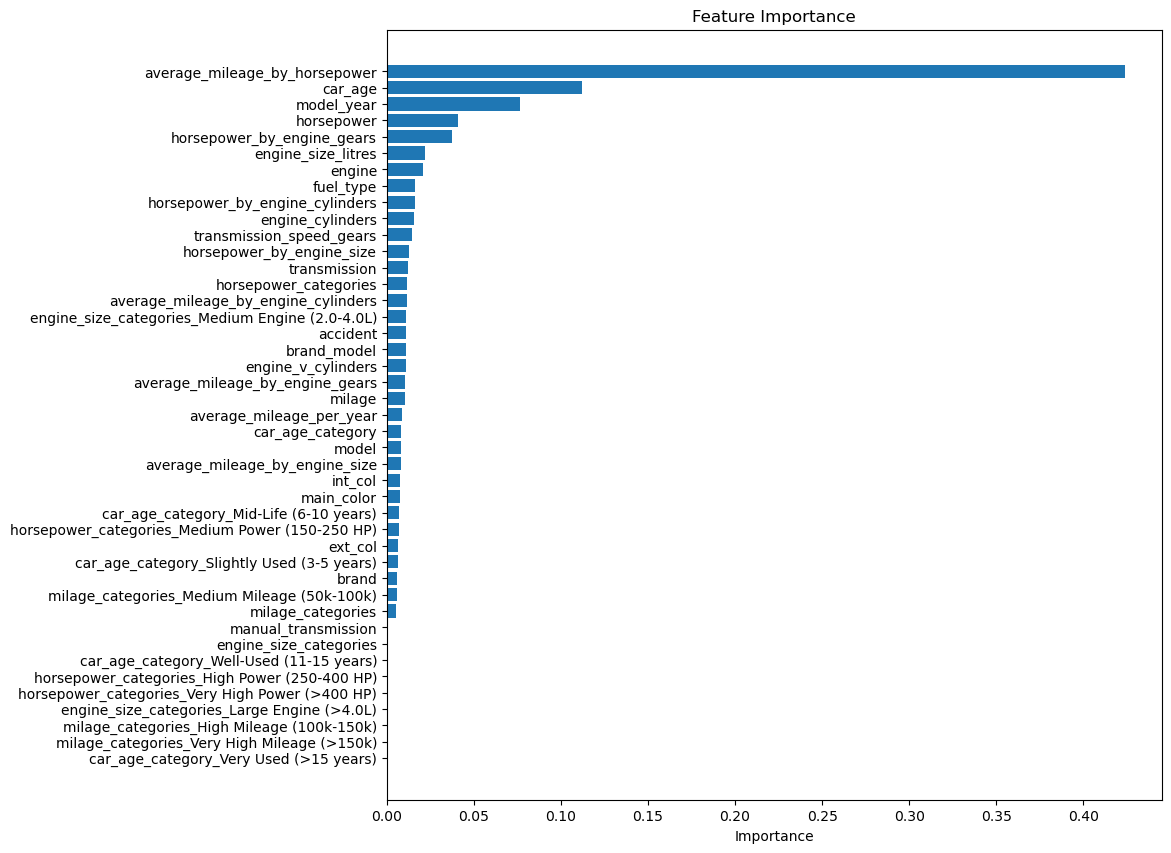

In [ ]:

xg_reg = XGBRegressor(random_state=42)

X = df_ml_one.drop(['price'], axis=1)
y = df_ml_one['price']
feature_names = X.columns
# Fit the regressor to the data
xg_reg.fit(X, y)

# Get feature importances
feature_importances = xg_reg.feature_importances_

# Sort the feature importances
sorted_idx = feature_importances.argsort()

# Plot feature importances as a horizontal bar plot
plt.figure(figsize=(10, 10))
plt.barh(range(len(feature_importances)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(feature_importances)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Importance")
plt.title("Feature Importance")
plt.show()



## XGBoost Fine Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
# Define XGBoost parameter grid
xgb_params = {
  'learning_rate': [0.05, 0.1, 0.2],  # Adjust learning rate based on your data
  'n_estimators': [50, 100, 150, 200],  # Adjust number of estimators based on complexity
  'max_depth': [3, 5, 7],  # Adjust max depth based on data complexity
  'subsample': [0.6, 0.8, 1.0],  # Experiment with subsampling for regularization
  'colsample_bytree': [0.6, 0.8, 1.0],  # Experiment with colsample for regularization
  'min_child_weight': [1, 3, 5],  # Controls minimum weight of each child leaf
  'gamma': [0, 0.3, 0.5],  # L2 regularization parameter (controls overfitting)
  'reg_lambda': [1, 10, 100],  # L1 regularization parameter (controls sparsity)
}

# Create XGBoost model with early stopping for robustness
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42, eval_metric='rmse',
                         use_label_encoder=False)  # Avoid label encoding if features are numerical

X = df_ml_one.drop(['price'], axis=1)
y = df_ml_one['price']
# create a train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Create GridSearchCV with XGBoost model and parameter grid
grid_search = GridSearchCV(xgb_model, xgb_params, scoring='neg_mean_squared_error', cv=5, verbose=0)

# Fit GridSearchCV on training data
grid_search.fit(X_train, y_train)

# Best model and parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print(f'Best XGBoost model: {best_model}')
print(f'Best XGBoost parameters: {best_params}')

Best XGBoost model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)
Best XGBoost parameters: {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 150, 'reg_lambda': 10, 'subsample': 0.8}


In [ ]:
# Make predictions with the best model
y_pred = best_model.predict(X_test)

# Evaluate performance (e.g., RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Best Model RMSE: {rmse:.2f}")

Best Model RMSE: 11008.37


In [ ]:
df_test_data = imputed_data.iloc[len_df_data:]

In [ ]:
# predict for scaled_test_data and save to csv
predictions = best_model.predict(df_test_data)

# save to csv and add the ids
df_predictions = pd.DataFrame({'id': ids, 'price': predictions})

df_predictions.to_csv('Final_Prediction.csv', index=False)
